# Import libraries and data

In [459]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from sklearn.metrics import ConfusionMatrixDisplay
from utils import get_uniprot, increase_stringency_CSF, print_p_val

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [322]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [323]:
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")
brain_exclusive = pd.read_csv(data_path + "Brain/Brain_exclusive.csv")

## Feature data sets

In [324]:
# all human proteins
df = pd.read_csv(data_path + "/Features/df_features.csv")
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated.csv")

In [325]:
# drop ectodomain column
df.drop(["Ectodomain_shedding"], axis=1, inplace=True)
df_detected.drop(["Ectodomain_shedding"], axis=1, inplace=True)
df_val.drop(["Ectodomain_shedding"], axis=1, inplace=True)
df_elevated.drop(["Ectodomain_shedding"], axis=1, inplace=True)

## CSF

In [326]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Marker proteins

### BIONDA

In [327]:
dementia_markers_BIONDA = pd.read_csv(data_path + "/Biomarker_discovery/BIONDA_dementia_markers.csv", sep=";")
ND_markers = pd.read_csv(data_path + "/Biomarker_discovery/BIONDA_ND_markers.csv", sep=";") # neurodegenerative disease

### DisGeNet

In [328]:
AD_markers = pd.read_csv(data_path + "/Biomarker_discovery/DisGeNet_AD_markers.tsv", sep="\t")
dementia_markers = pd.read_csv(data_path + "/Biomarker_discovery/DisGeNet_dementia_markers.tsv", sep="\t")

## Bai et al. (2020)

Deep Multilayer Brain Proteomics Identifies Molecular Networks in Alzheimer’s Disease Progression: https://doi.org/10.1016/j.neuron.2019.12.015

In [329]:
Bai2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_brain_tissue.txt", header=None, 
    names=["Uniprot"])
Bai2020_brain_biomarkers = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_brain_tissue_biomarker_candidates.txt", 
    header=None, names=["Uniprot"])
Bai2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_CSF.txt", header=None, names=["Uniprot"])
Bai2020_CSF_biomarkers = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_CSF_biomarker_candidates.txt", 
    header=None, names=["Uniprot"])


Bai2020_brain["Uniprot"] = Bai2020_brain["Uniprot"].apply(get_uniprot)
Bai2020_brain_biomarkers["Uniprot"] = Bai2020_brain_biomarkers["Uniprot"].apply(get_uniprot)
Bai2020_CSF["Uniprot"] = Bai2020_CSF["Uniprot"].apply(get_uniprot)
Bai2020_CSF_biomarkers["Uniprot"] = Bai2020_CSF_biomarkers["Uniprot"].apply(get_uniprot)

## Higginbotham et al. (2020)

Integrated proteomics reveals brain-based cerebrospinal fluid biomarkers in asymptomatic and symptomatic Alzheimer’s disease: https://doi.org/10.1126/sciadv.aaz9360

In [330]:
def get_uniprot_alt(string):
    _, uniprot = string.split("|")
    
    if "-" in uniprot:
        uniprot, _ = uniprot.split("-")

    return uniprot

In [331]:
Higginbotham2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_brain.txt", header=None, 
    names=["Uniprot"])
Higginbotham2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_CSF.txt", 
    header=None, names=["Uniprot"])

In [332]:
Higginbotham2020_brain["Uniprot"] = Higginbotham2020_brain["Uniprot"].apply(get_uniprot_alt)
Higginbotham2020_CSF["Uniprot"] = Higginbotham2020_CSF["Uniprot"].apply(get_uniprot_alt)

## Biomarker list (Nerea, MIRIADE)

In [333]:
biomarkers_Nerea = pd.read_csv(data_path + "/Biomarker_discovery/Biomarkers_MIRIADE_Nerea.tsv", sep="\t", header=0, 
    names=["Uniprot", "Gene name", "Protein name"])
biomarkers_Nerea

,Uniprot,Gene name,Protein name
0,Q9Y6Q6,TNFRSF11A,TNR11
1,Q9Y653,ADGRG1,AGRG1
2,Q9Y624,F11R,JAM1
3,Q9Y336,SIGLEC9,SIGL9
4,Q9Y2T3,GDA,GUAD
...,...,...,...
285,O00300,TNFRSF11B,TR11B
286,O00253,AGRP,AGRP
287,P02748,C9,CO9
288,P01011,SERPINA3,AACT


## Model and scaler

In [334]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "rb") as f:  
    lr_l2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    lr_l2_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    lr_l2_3plus = pickle.load(f)

In [335]:
with open(os.getcwd() + "/Models/LogisticClassifier_L1.pkl", "rb") as f:  
    lr_l1 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_2plus.pkl", "rb") as f:  
    lr_l1_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_3plus.pkl", "rb") as f:  
    lr_l1_3plus = pickle.load(f)

In [336]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction

In [337]:
# # model = lr_l1
# # model_2plus = lr_l1_2plus
# # model_3plus = lr_l1_3plus

# model = lr_l2
# model_2plus = lr_l2_2plus
# model_3plus = lr_l2_3plus

In [338]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
        'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
        'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
        'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel', 'Glycosylation']

In [339]:
# define variables and target
X = df.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df["CSF"]

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

# lr_l2.classes_ # -1 and 1

In [348]:
df_pred = df.copy()
models = [lr_l1, lr_l1_2plus, lr_l1_3plus, lr_l2, lr_l2_2plus, lr_l2_3plus]
model_name = ["lr_l1", "lr_l1_2plus", "lr_l1_3plus", "lr_l2", "lr_l2_2plus", "lr_l2_3plus"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
    # create dataframe of probabilities
    preds = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
    column_name = "Score_" + model_name[i]
    df_pred[column_name] = preds["CSF_proba"]

# proba_l1 = lr_l1.predict_proba(X_scal)
# proba_l1_2plus = lr_l1_2plus.predict_proba(X_scal)
# proba_l1_3plus = lr_l1_3plus.predict_proba(X_scal)
# proba_l2 = lr_l2.predict_proba(X_scal)
# proba_l2_2plus = lr_l2_2plus.predict_proba(X_scal)
# proba_l2_3plus = lr_l2_3plus.predict_proba(X_scal)

# # create dataframe of probabilities
# preds_l1 = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
# preds_2plus = pd.DataFrame(proba_2plus, columns=["non_CSF_proba", "CSF_proba"])
# preds_3plus = pd.DataFrame(proba_3plus, columns=["non_CSF_proba", "CSF_proba"])

# order dataframe by probabilities
df_pred.sort_values(by="Score_lr_l1", ascending=False, inplace=True)
# reindex to see protein rank according to probability
df_pred.reset_index(drop=True, inplace=True)

df_pred

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,Signal peptide,RNA_binding,DNA_binding,CSF,Score_lr_l1,Score_lr_l1_2plus,Score_lr_l1_3plus,Score_lr_l2,Score_lr_l2_2plus,Score_lr_l2_3plus
0,Q7Z5P9,MKLILWYLVVALWCFFKDVEALLYRQKSDGKIAASRSGGFSYGSSS...,8384,8.052433e+05,0.084566,0.015983,0.018488,0.054031,0.014671,0.176885,...,1,0,0,1,0.998539,0.999923,0.999939,0.999825,0.999976,0.999988
1,Q8WXI7,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,14507,1.519157e+06,0.054388,0.002482,0.031433,0.055628,0.021783,0.051837,...,0,0,0,1,0.995249,0.996953,0.972542,0.998067,0.998499,0.988182
2,Q6V0I7,MDLAPDRATGRPWLPLHTLSVSQLLRVFWLLSLLPGQAWVHGAEPR...,4981,5.426802e+05,0.060430,0.013853,0.070066,0.053804,0.040554,0.072275,...,1,0,0,1,0.990933,0.997963,0.997709,0.995219,0.998342,0.998445
3,P02458,MIRLGAPQTLVLLTLLVAAVLRCQGQDVQEAGSCVQDGQRYNDKDV...,1487,1.417837e+05,0.090114,0.012777,0.041695,0.053127,0.016812,0.273033,...,1,0,0,1,0.990780,0.998937,0.999862,0.997871,0.998777,0.999885
4,P02452,MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...,1464,1.389098e+05,0.095628,0.012295,0.045082,0.051230,0.018443,0.267077,...,1,0,0,1,0.990730,0.998943,0.999847,0.998157,0.998823,0.999876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20298,A6NJY4,MLLGSLWGRCHPGRCALFLILALLLDAVGLVLLLLGILAPLSSWDF...,79,8.765605e+03,0.075949,0.025316,0.037975,0.025316,0.037975,0.075949,...,0,0,0,-1,0.005229,0.000793,0.000285,0.001770,0.000517,0.000092
20299,Q17RH7,MTHDKSWRRCSISGSTKCRCGSRIAGPNALGSGGSRSSSSSSRSIL...,258,2.413899e+04,0.019380,0.019380,0.003876,0.000000,0.003876,0.031008,...,0,0,0,-1,0.005054,0.000048,0.000031,0.006877,0.000039,0.000015
20300,Q9P1C3,MVRPHLLKKKILGRVWWLMPVVLALWEAEVGGSLEVRSLRPAWPTW,46,5.406509e+03,0.065217,0.000000,0.000000,0.065217,0.000000,0.065217,...,0,0,0,-1,0.004288,0.001562,0.000205,0.001317,0.001749,0.000162
20301,Q8WY50,MKELLRLKHCKHLLTTHVHSPWTPSLTLTPSLLTLDTLTHPRHRHS...,150,1.667982e+04,0.006667,0.006667,0.040000,0.006667,0.006667,0.026667,...,0,0,0,-1,0.004056,0.000189,0.001037,0.001486,0.000090,0.001045


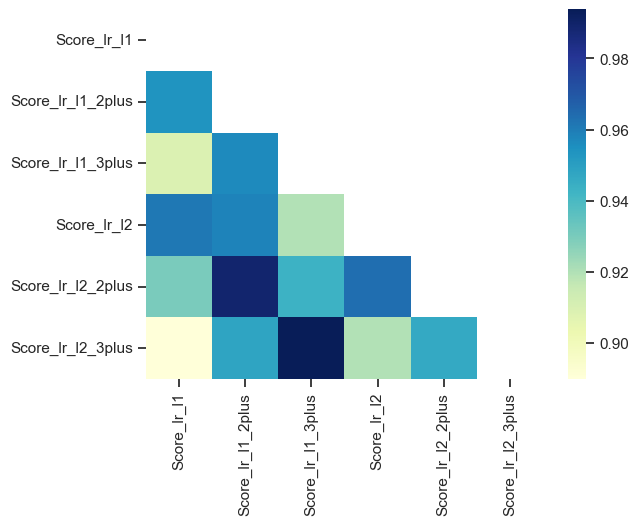

In [356]:
corr_models = df_pred[["Score_lr_l1", "Score_lr_l1_2plus", "Score_lr_l1_3plus", "Score_lr_l2", "Score_lr_l2_2plus", "Score_lr_l2_3plus"]].corr()
mask = np.triu(np.ones_like(corr_models, dtype=bool))
sns.heatmap(corr_models, cmap="YlGnBu", mask=mask)

plt.show()

In [444]:
df_detected_pred = df_pred[df_pred["Uniprot"].isin(df_detected["Uniprot"])]
print("Number of proteins in brain detected set:", len(df_detected_pred))
df_elevated_pred = df_detected_pred[df_detected_pred["Uniprot"].isin(df_elevated["Uniprot"])]
print("Number of proteins in brain elevated set:", len(df_elevated_pred))
df_val_pred = df_detected_pred[df_detected_pred["Uniprot"].isin(df_val["Uniprot"])]
print("Number of proteins in brain detected validation set:", len(df_val_pred))

Number of proteins in brain detected set: 15990
Number of proteins in brain elevated set: 2542
Number of proteins in brain detected validation set: 13448


In [367]:
# create datasets without ambiguous proteins
df_val_pred_2plus = increase_stringency_CSF(df_val_pred, csf, 2)
df_elevated_pred_2plus = increase_stringency_CSF(df_elevated_pred, csf, 2)
df_val_pred_3plus = increase_stringency_CSF(df_val_pred, csf, 2)
df_elevated_pred_3plus = increase_stringency_CSF(df_elevated_pred, csf, 3)

Number of CSF proteins to be removed: 1643
Number of CSF proteins left: 2425
Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of CSF proteins to be removed: 1643
Number of CSF proteins left: 2425
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541


In [475]:
# create subsets of datasets based on CSF class annotation
df_elevated_CSF = df_elevated_pred[df_elevated_pred["CSF"] == 1]
df_elevated_non_CSF = df_elevated_pred[df_elevated_pred["CSF"] == -1]

df_detected_CSF = df_detected_pred[df_detected_pred["CSF"] == 1]
df_detected_non_CSF = df_detected_pred[df_detected_pred["CSF"] == -1]

df_val_CSF = df_val_pred[df_val_pred["CSF"] == 1]
df_val_non_CSF = df_val_pred[df_val_pred["CSF"] == -1]
df_val_CSF_2plus = df_val_pred_2plus[df_val_pred_2plus["CSF"] == 1]
df_val_non_CSF_2plus = df_val_pred_2plus[df_val_pred_2plus["CSF"] == -1]
df_val_CSF_3plus = df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]
df_val_non_CSF_3plus = df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]

# Examine prediction results

## Check distribution of probabilities across CSF classes

### L1 regularization

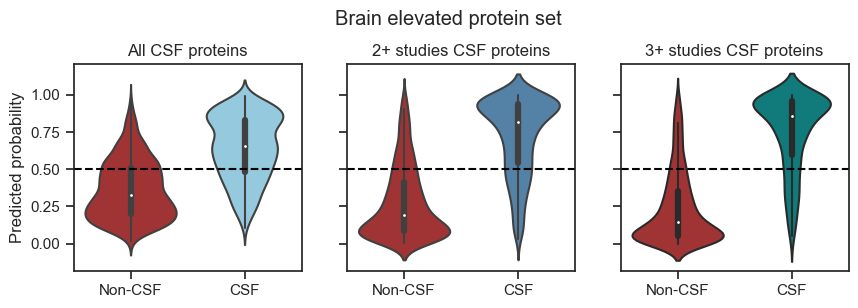

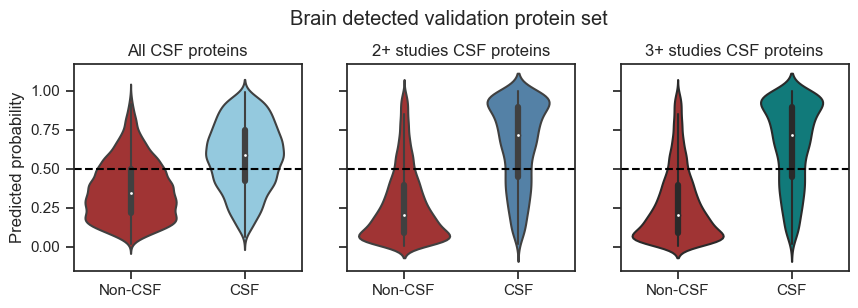

In [454]:
# brain elevated
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain elevated protein set")

sns.violinplot(x="CSF", y="Score_lr_l1", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l1_2plus", data=df_elevated_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l1_3plus", data=df_elevated_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

fig.savefig(fig_path + "Probability_scores_brain_elevated_L1.png", bbox_inches="tight")

# brain detected (not in training data)
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.violinplot(x="CSF", y="Score_lr_l1", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l1_2plus", data=df_val_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l1_2plus", data=df_val_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_val_L1.png", bbox_inches="tight")

In [434]:
print(df_val_pred.groupby("CSF").median()["Score_lr_l1"])
print(df_val_pred_2plus.groupby("CSF").median()["Score_lr_l1_2plus"])
print(df_val_pred_3plus.groupby("CSF").median()["Score_lr_l1_3plus"])

CSF
-1    0.345964
 1    0.587477
Name: Score_lr_l1, dtype: float64
CSF
-1    0.200591
 1    0.712938
Name: Score_lr_l1_2plus, dtype: float64
CSF
-1    0.149331
 1    0.713690
Name: Score_lr_l1_3plus, dtype: float64


### L2 regularization

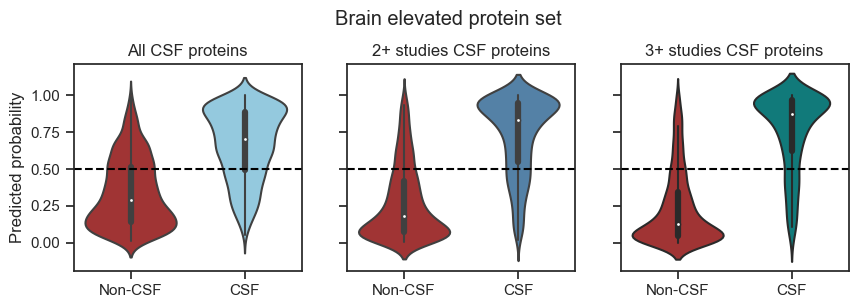

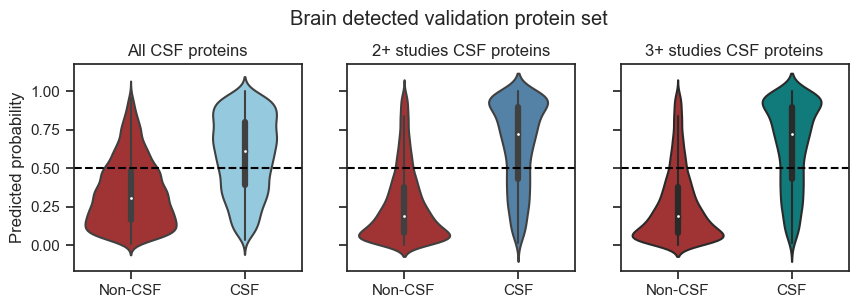

In [516]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.suptitle("Brain elevated protein set")
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)

sns.violinplot(x="CSF", y="Score_lr_l2", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l2_2plus", data=df_elevated_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="Score_lr_l2_3plus", data=df_elevated_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

fig.savefig(fig_path + "Probability_scores_brain_elevated_L2.png", bbox_inches="tight")

# brain detected (not in training data)
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.violinplot(x="CSF", y="Score_lr_l2", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
ax[0].set_xticklabels(["Non-CSF", "CSF"])
sns.violinplot(x="CSF", y="Score_lr_l2_2plus", data=df_val_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
ax[1].set_xticklabels(["Non-CSF", "CSF"])
sns.violinplot(x="CSF", y="Score_lr_l2_2plus", data=df_val_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")
ax[2].set_xticklabels(["Non-CSF", "CSF"])

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_val_L2.png", bbox_inches="tight")

In [433]:
print(df_val_pred.groupby("CSF").median()["Score_lr_l2"])
print(df_val_pred_2plus.groupby("CSF").median()["Score_lr_l2_2plus"])
print(df_val_pred_3plus.groupby("CSF").median()["Score_lr_l2_3plus"])

CSF
-1    0.306825
 1    0.611334
Name: Score_lr_l2, dtype: float64
CSF
-1    0.186526
 1    0.719756
Name: Score_lr_l2_2plus, dtype: float64
CSF
-1    0.130743
 1    0.714374
Name: Score_lr_l2_3plus, dtype: float64


## Prediction confidence across number of studies proteins were found in

In [447]:
studies_proba_val = csf[["Uniprot", "#Studies"]].merge(df_val_CSF[["Uniprot", "Score_lr_l2", "Score_lr_l2_2plus", 
    "Score_lr_l2_3plus"]], on="Uniprot", how="inner")
studies_proba_elevated = csf[["Uniprot", "#Studies"]].merge(df_elevated_CSF[["Uniprot", "Score_lr_l2", "Score_lr_l2_2plus", 
    "Score_lr_l2_3plus"]], on="Uniprot", how="inner")

In [460]:
studies_proba_val

,Uniprot,#Studies,Score_lr_l2,Score_lr_l2_2plus,Score_lr_l2_3plus
0,Q6K0P9,1,0.352086,0.259811,0.160086
1,P09529,5,0.808250,0.868502,0.753901
2,P61019,3,0.885680,0.945736,0.982147
3,Q9GZX9,7,0.590276,0.492183,0.358665
4,Q96RP7,4,0.618175,0.572422,0.575326
...,...,...,...,...,...
4063,Q86T82,1,0.248421,0.124888,0.093839
4064,Q6ZMZ0,1,0.712847,0.609986,0.744058
4065,Q96PZ2,1,0.290302,0.262154,0.101976
4066,Q9ULJ1,1,0.563258,0.377375,0.316555


In [526]:
studies_proba_val.groupby("#Studies").describe()["Score_lr_l2_3plus"]

,count,mean,std,min,25%,50%,75%,max
#Studies,,,,,,,,
1,1643.0,0.344885,0.290688,0.001630,0.098896,0.256745,0.550910,0.999787
2,630.0,0.488236,0.308556,0.004229,0.206300,0.461543,0.763192,0.996662
3,378.0,0.575189,0.295583,0.004358,0.346942,0.597828,0.842832,0.999741
4,278.0,0.646592,0.262244,0.040733,0.463180,0.670935,0.892109,0.999643
5,346.0,0.670690,0.279380,0.020189,0.461079,0.760711,0.922142,0.999950
6,423.0,0.745330,0.251256,0.032714,0.622443,0.830222,0.938699,0.999928
7,370.0,0.809604,0.215897,0.018650,0.714840,0.890585,0.969117,0.999876


In [524]:
studies_proba_elevated.groupby("#Studies").describe()["Score_lr_l2_3plus"]

,count,mean,std,min,25%,50%,75%,max
#Studies,,,,,,,,
1,303.0,0.383573,0.308761,0.005043,0.127445,0.282135,0.600270,0.999760
2,151.0,0.505147,0.315354,0.012780,0.220592,0.482487,0.797173,0.999750
3,67.0,0.579242,0.308308,0.023795,0.323617,0.586606,0.895456,0.995668
4,67.0,0.751414,0.273802,0.051956,0.592506,0.894375,0.951603,0.998469
5,105.0,0.729889,0.275358,0.021448,0.617034,0.798393,0.968271,0.999645
6,140.0,0.795899,0.229103,0.083796,0.723639,0.882814,0.959448,0.998303
7,162.0,0.817644,0.221008,0.096430,0.718570,0.924575,0.976352,0.999350


In [466]:
#### TO DO ####
# multiple testing correction
    
p_elevated = []
print("Brain elevated protein set")
for i in range(6):
    _, p = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == i+1]["Score_lr_l2"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == i+2]["Score_lr_l2"])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_elevated.append(p)

p_vals_val = []
print("Brain detected validation protein set")
for i in range(6):
    _, p = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == i+1]["Score_lr_l2"], 
                        studies_proba_val[studies_proba_val["#Studies"] == i+2]["Score_lr_l2"])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_val.append(p)


Brain elevated protein set
Comparison of 1 and 2: < 0.0001
Comparison of 2 and 3: 0.2656
Comparison of 3 and 4: 0.0017
Comparison of 4 and 5: 0.4862
Comparison of 5 and 6: 0.1957
Comparison of 6 and 7: 0.2741
Brain detected validation protein set
Comparison of 1 and 2: < 0.0001
Comparison of 2 and 3: 0.0003
Comparison of 3 and 4: 0.0020
Comparison of 4 and 5: 0.0951
Comparison of 5 and 6: 0.0005
Comparison of 6 and 7: < 0.0001


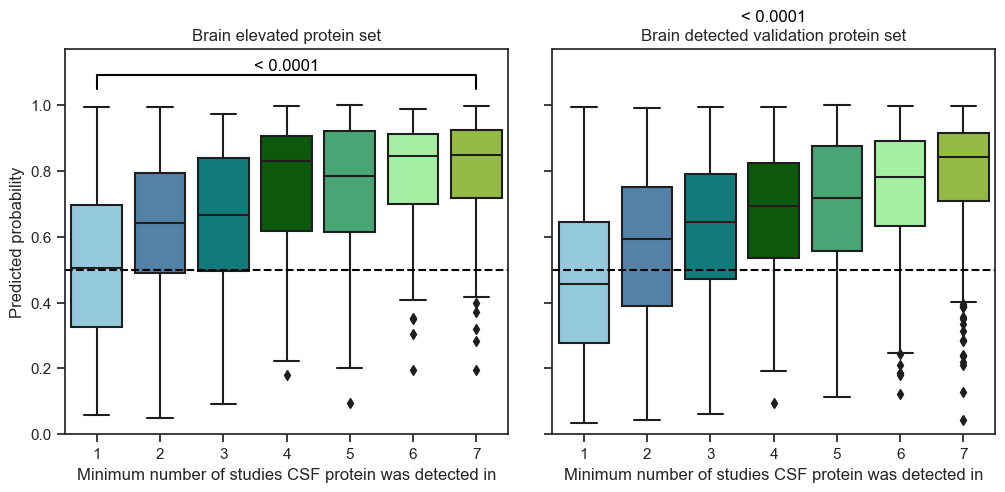

In [512]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["Score_lr_l2"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 7]["Score_lr_l2"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["Score_lr_l2"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 7]["Score_lr_l2"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

palette=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"]

sns.boxplot(x="#Studies", y="Score_lr_l2", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(3, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="Score_lr_l2", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(3, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number.png", bbox_inches="tight")

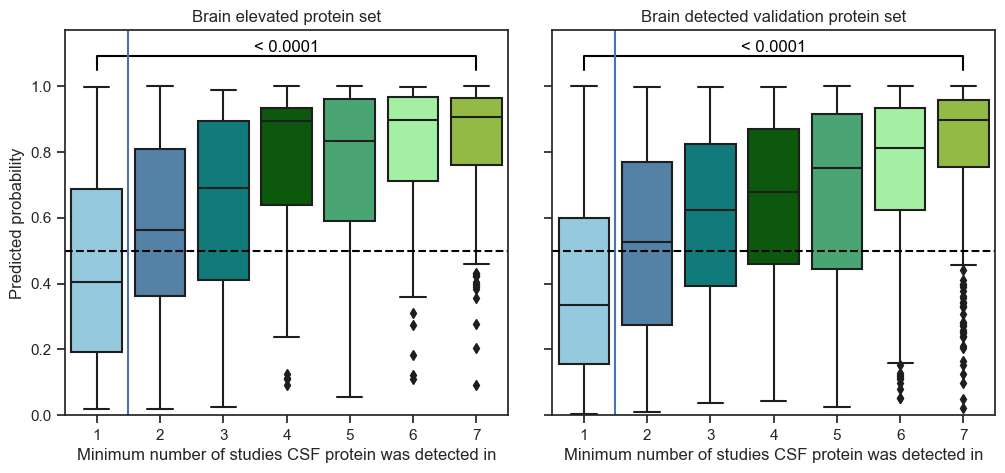

In [520]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["Score_lr_l2_2plus"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 7]["Score_lr_l2_2plus"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["Score_lr_l2_2plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 7]["Score_lr_l2_2plus"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

sns.boxplot(x="#Studies", y="Score_lr_l2_2plus", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(3, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="Score_lr_l2_2plus", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(3, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")
    ax[i].axvline(0.5)
    
plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number_2plus.png", bbox_inches="tight")

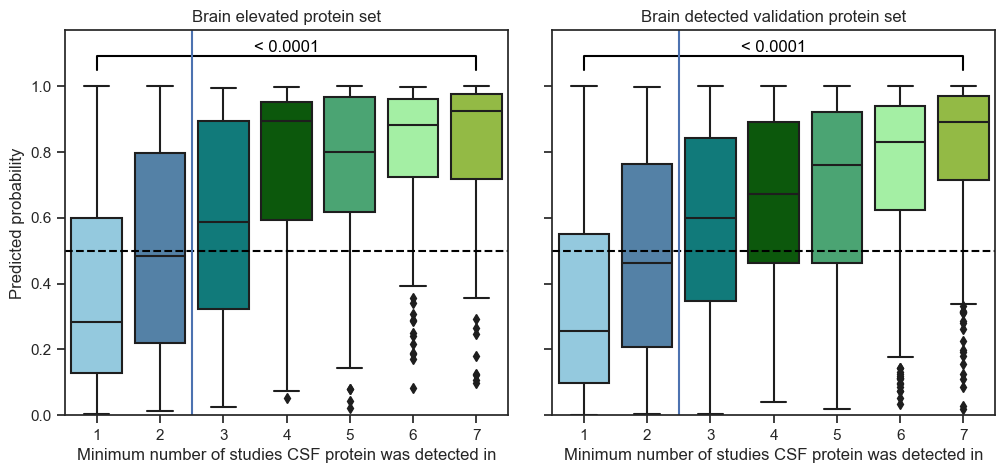

In [518]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["Score_lr_l2_3plus"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 7]["Score_lr_l2_3plus"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["Score_lr_l2_3plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 7]["Score_lr_l2_3plus"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

sns.boxplot(x="#Studies", y="Score_lr_l2_3plus", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(3, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="Score_lr_l2_3plus", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(3, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")
    ax[i].axvline(1.5)

plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number_3plus.png", bbox_inches="tight")

## Compare difference in brain expression levels between annotations and predictions

In [538]:
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])
brain_exp_CSF = brain_exp.merge(df_detected_pred[["Uniprot", "CSF", "Score_lr_l2", "Score_lr_l2_2plus", "Score_lr_l2_3plus"]], 
    on="Uniprot", how="inner")
brain_exp_CSF["Score_binary_lr_l2"] = np.where(brain_exp_CSF["Score_lr_l2"] > 0.5, 1, -1)
brain_exp_CSF["Score_binary_lr_l2_2plus"] = np.where(brain_exp_CSF["Score_lr_l2_2plus"] > 0.5, 1, -1)
brain_exp_CSF["Score_binary_lr_l2_3plus"] = np.where(brain_exp_CSF["Score_lr_l2_3plus"] > 0.5, 1, -1)
brain_exp_CSF

,Uniprot,Brain expression,log2(Brain expression),CSF,Score_lr_l2,Score_lr_l2_2plus,Score_lr_l2_3plus,Score_binary_lr_l2,Score_binary_lr_l2_2plus,Score_binary_lr_l2_3plus
0,O43612,352.2,8.460251,1,0.727881,0.619663,0.717485,1,1,1
1,P51861,38856.0,15.245850,-1,0.015004,0.004298,0.004018,-1,-1,-1
2,P01185,5271.0,12.363861,1,0.919971,0.917367,0.936019,1,1,1
3,Q96PE5,149.9,7.227857,1,0.256090,0.304301,0.143914,-1,-1,-1
4,Q9BZE3,34.3,5.100137,-1,0.024153,0.005739,0.004206,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
2537,A4D1E1,2.2,1.137504,-1,0.286426,0.160876,0.092689,-1,-1,-1
2538,Q05481,30.4,4.925999,-1,0.151375,0.119000,0.025985,-1,-1,-1
2539,Q8TCW7,1.3,0.378512,-1,0.794671,0.706180,0.866832,1,1,1
2540,Q96LW9,43.6,5.446256,-1,0.058427,0.034733,0.015604,-1,-1,-1


In [539]:
# annotations
CSF_annot = brain_exp_CSF[brain_exp_CSF["CSF"] == 1]
non_CSF_annot = brain_exp_CSF[brain_exp_CSF["CSF"] == -1]
_, p_annot = mannwhitneyu(CSF_annot["Brain expression"], non_CSF_annot["Brain expression"])
print("P-value for annotations:", p_annot)

# predictions
CSF_pred = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2"] == 1]
non_CSF_pred = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2"] == -1]
_, p_pred = mannwhitneyu(CSF_pred["Brain expression"], non_CSF_pred["Brain expression"])
print("P-value for predictions:", p_pred)

CSF_pred_2plus = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2_2plus"] == 1]
non_CSF_pred_2plus = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2_2plus"] == -1]
_, p_pred_2plus = mannwhitneyu(CSF_pred_2plus["Brain expression"], non_CSF_pred_2plus["Brain expression"])
print("P-value for predictions:", p_pred_2plus)

CSF_pred_3plus = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2_3plus"] == 1]
non_CSF_pred_3plus = brain_exp_CSF[brain_exp_CSF["Score_binary_lr_l2_3plus"] == -1]
_, p_pred_3plus = mannwhitneyu(CSF_pred_3plus["Brain expression"], non_CSF_pred_3plus["Brain expression"])
print("P-value for predictions:", p_pred_3plus)

P-value for annotations: 1.1177729870554354e-38
P-value for predictions: 6.70632928141863e-13
P-value for predictions: 1.625445424481053e-08
P-value for predictions: 1.0351850544431292e-09


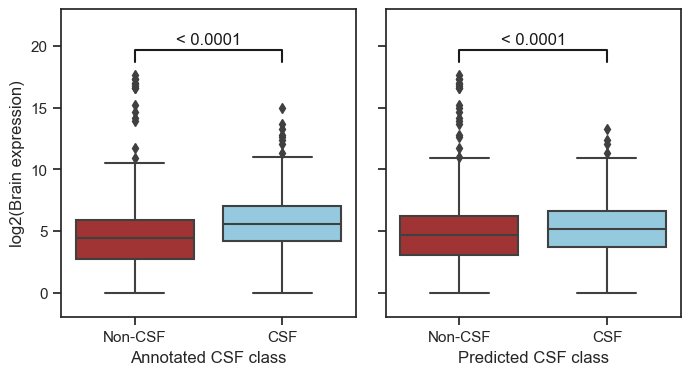

In [566]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
fig.subplots_adjust(wspace=0.1)

palette=["firebrick", "skyblue"]

sns.boxplot(x="CSF", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[0])
ax[0].set(xlabel="Annotated CSF class")
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[0].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c="k")
ax[0].text(.5, y+1.2, print_p_val(p_annot), ha="center", va="bottom", color="k")
ax[0].set_xticklabels(["Non-CSF", "CSF"])

sns.boxplot(x="Score_binary_lr_l2_2plus", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[1])
ax[1].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[1].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
ax[1].text(0.5, y+1.2, print_p_val(p_pred), ha="center", va="bottom", color="k")
ax[1].set_xticklabels(["Non-CSF", "CSF"])

plt.show()
fig.savefig(fig_path + "Bar_brain_expression_vs_CSF_class_pred_annot.png", bbox_inches="tight")

In [563]:
TN = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1) & (brain_exp_CSF["Score_binary_lr_l2_2plus"] == -1)]
FP = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1) & (brain_exp_CSF["Score_binary_lr_l2_2plus"] == 1)]
TP = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1) & (brain_exp_CSF["Score_binary_lr_l2_2plus"] == 1)]
FN = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1) & (brain_exp_CSF["Score_binary_lr_l2_2plus"] == -1)]

P = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1)]
N = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1)]
PP = brain_exp_CSF[(brain_exp_CSF["Score_binary_lr_l2_2plus"] == 1)]
PN = brain_exp_CSF[(brain_exp_CSF["Score_binary_lr_l2_2plus"] == -1)]

l = [TN, N, FP, TP, P, FN, PP, PN]

In [572]:
print("Brain expression positives:", np.median(P["log2(Brain expression)"]))
print("Brain expression negatives:", np.median(N["log2(Brain expression)"]))
print("Brain expression predicted positives:", np.median(PP["log2(Brain expression)"]))
print("Brain expression predicted negatives:", np.median(PN["log2(Brain expression)"]))

Brain expression positives: 5.532940288372874
Brain expression negatives: 4.472487771462744
Brain expression predicted positives: 5.137503523749935
Brain expression predicted negatives: 4.678071905112637


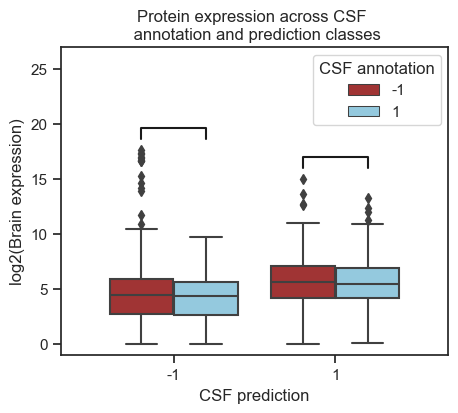

In [573]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.boxplot(y="log2(Brain expression)", x="CSF", hue="Score_binary_lr_l2_2plus", data=brain_exp_CSF, 
    palette=["firebrick", "skyblue"])
ax.legend(title="CSF annotation", loc="upper right")#, bbox_to_anchor=(1.2, 1))
ax.set(xlabel="CSF prediction", ylabel="log2(Brain expression)", 
    title="Protein expression across CSF \n annotation and prediction classes", ylim=(-1,27))


y, h = max(TN["log2(Brain expression)"]) + 1, 1
ax.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=1.5, color="k")
ax.text(0, y+1.2, "", ha="center", va="bottom", color="k")
y, h = max(FN["log2(Brain expression)"]) + 1, 1
ax.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=1.5, color="k")
ax.text(1, y+1.2, "", ha="center", va="bottom", color="k")

plt.show()

# Biomarkers

## Overlap of biomarker ranking with known disease markers

### Dementia  (BIONDA)

Number of associated markers: 186
Percent predicted as CSF secreted: 0.5913978494623656
Percent predicted as non-CSF secreted: 0.40860215053763443


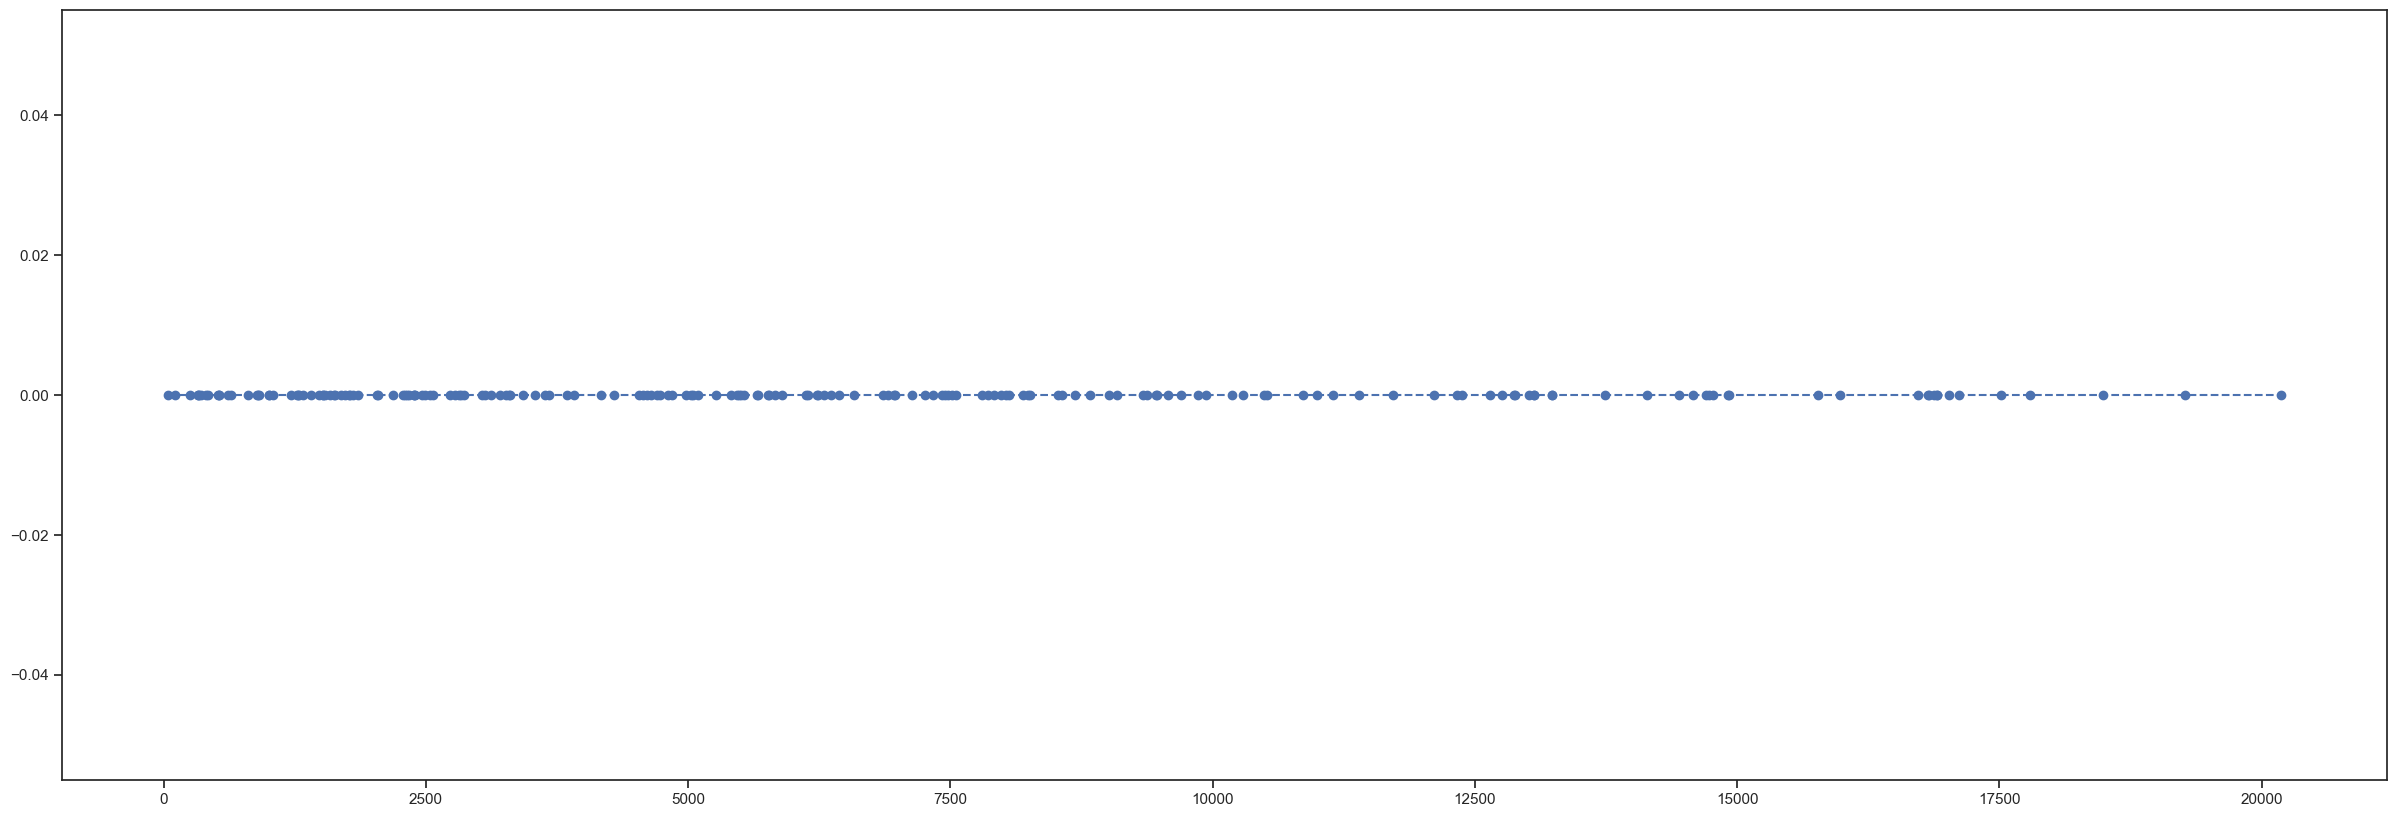

In [278]:
# keep only significant associated markers
dementia_markers_sig = dementia_markers_BIONDA[dementia_markers_BIONDA["Score"] < 0.05]
# keep only markers
df_pred_dementia_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(dementia_markers_sig["MarkerID"])] 
print("Number of associated markers:", len(df_pred_dementia_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["CSF_proba"] > 0.5])/len(df_pred_dementia_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["CSF_proba"] < 0.5])/len(df_pred_dementia_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.plot(df_pred_dementia_markers.index, np.zeros(len(df_pred_dementia_markers.index)), "--bo")
plt.show()

### Neurodegenerative diseases (BIONDA)

Number of associated markers: 89
Percent predicted as CSF secreted: 0.48314606741573035
Percent predicted as non-CSF secreted: 0.5168539325842697


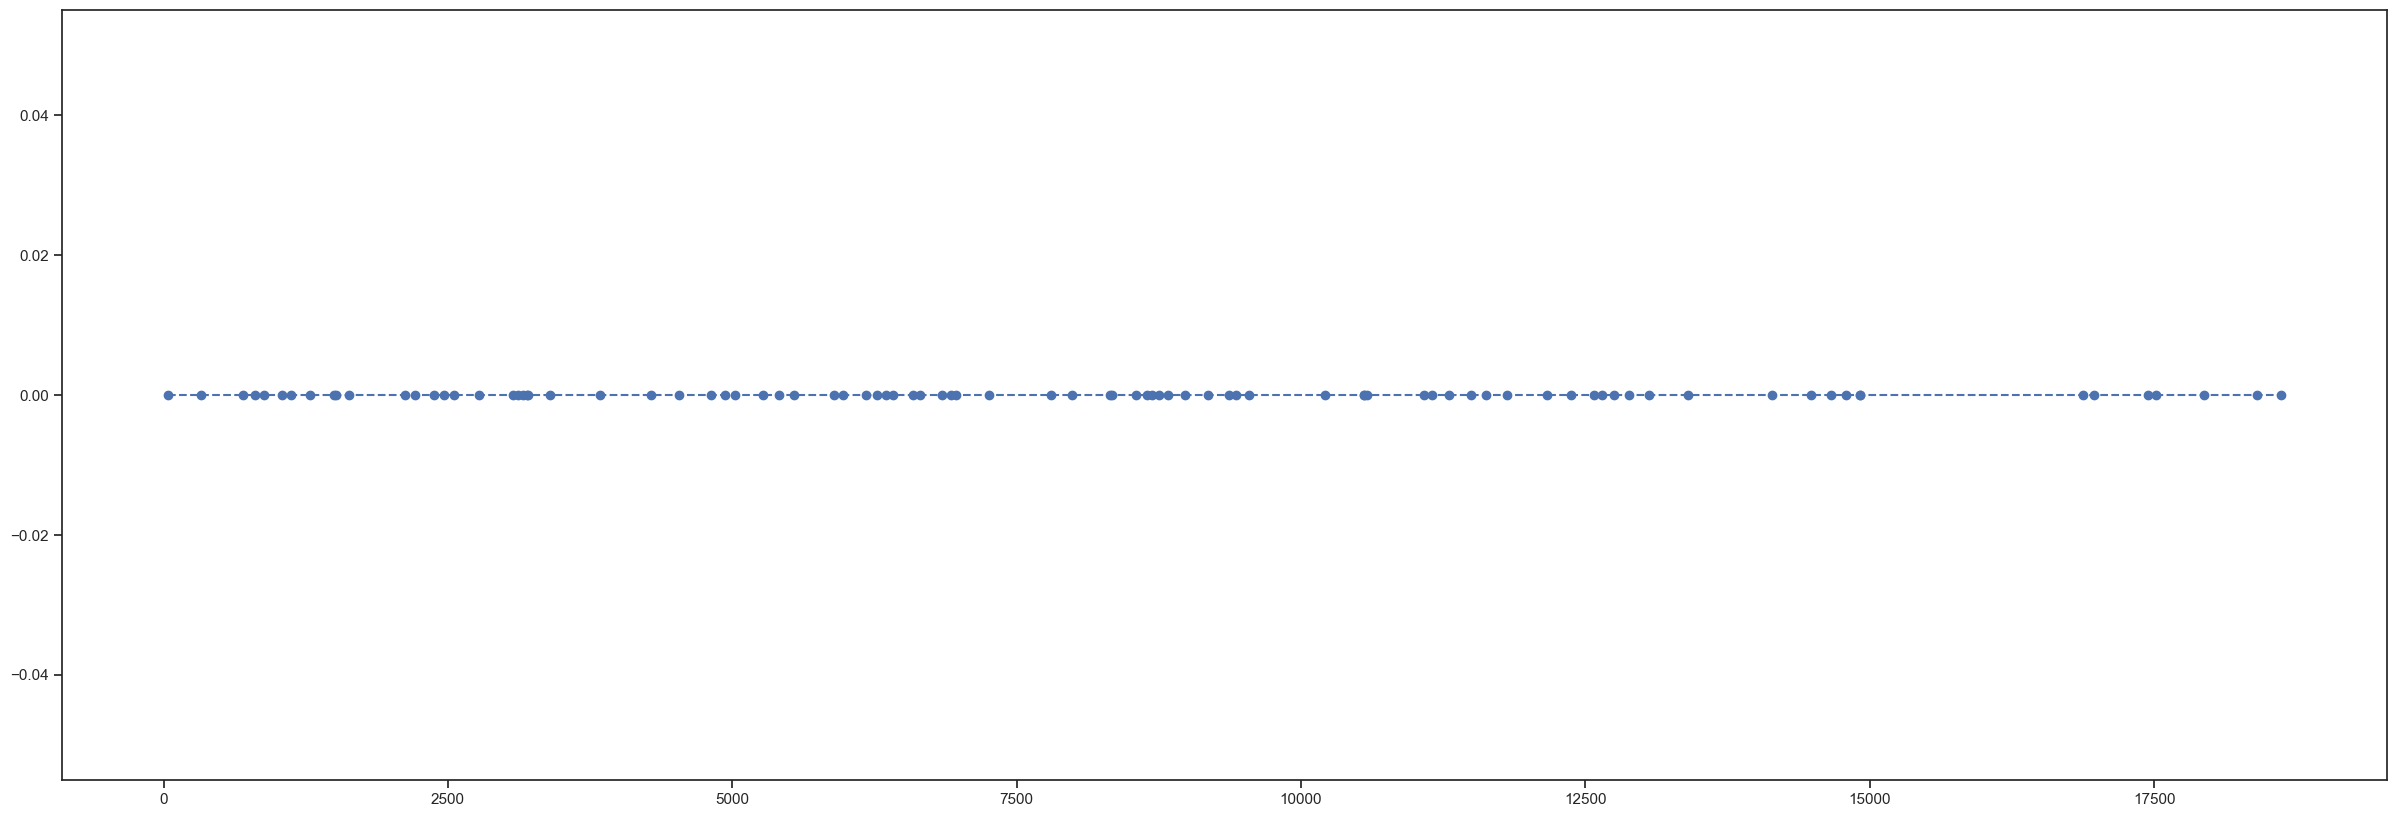

In [279]:
ND_markers_sig = ND_markers[ND_markers["Score"] < 0.05]
df_pred_ND_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(ND_markers_sig["MarkerID"])] 
print("Number of associated markers:", len(df_pred_ND_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_ND_markers[df_pred_ND_markers["CSF_proba"] > 0.5])/len(df_pred_ND_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_ND_markers[df_pred_ND_markers["CSF_proba"] < 0.5])/len(df_pred_ND_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.plot(df_pred_ND_markers.index, np.zeros(len(df_pred_ND_markers.index)), "--bo")
plt.show()

### Alzheimer's Disease (DisGeNet)

Number of associated markers: 124
Percent predicted as CSF secreted: 0.6370967741935484
Percent predicted as non-CSF secreted: 0.3629032258064516


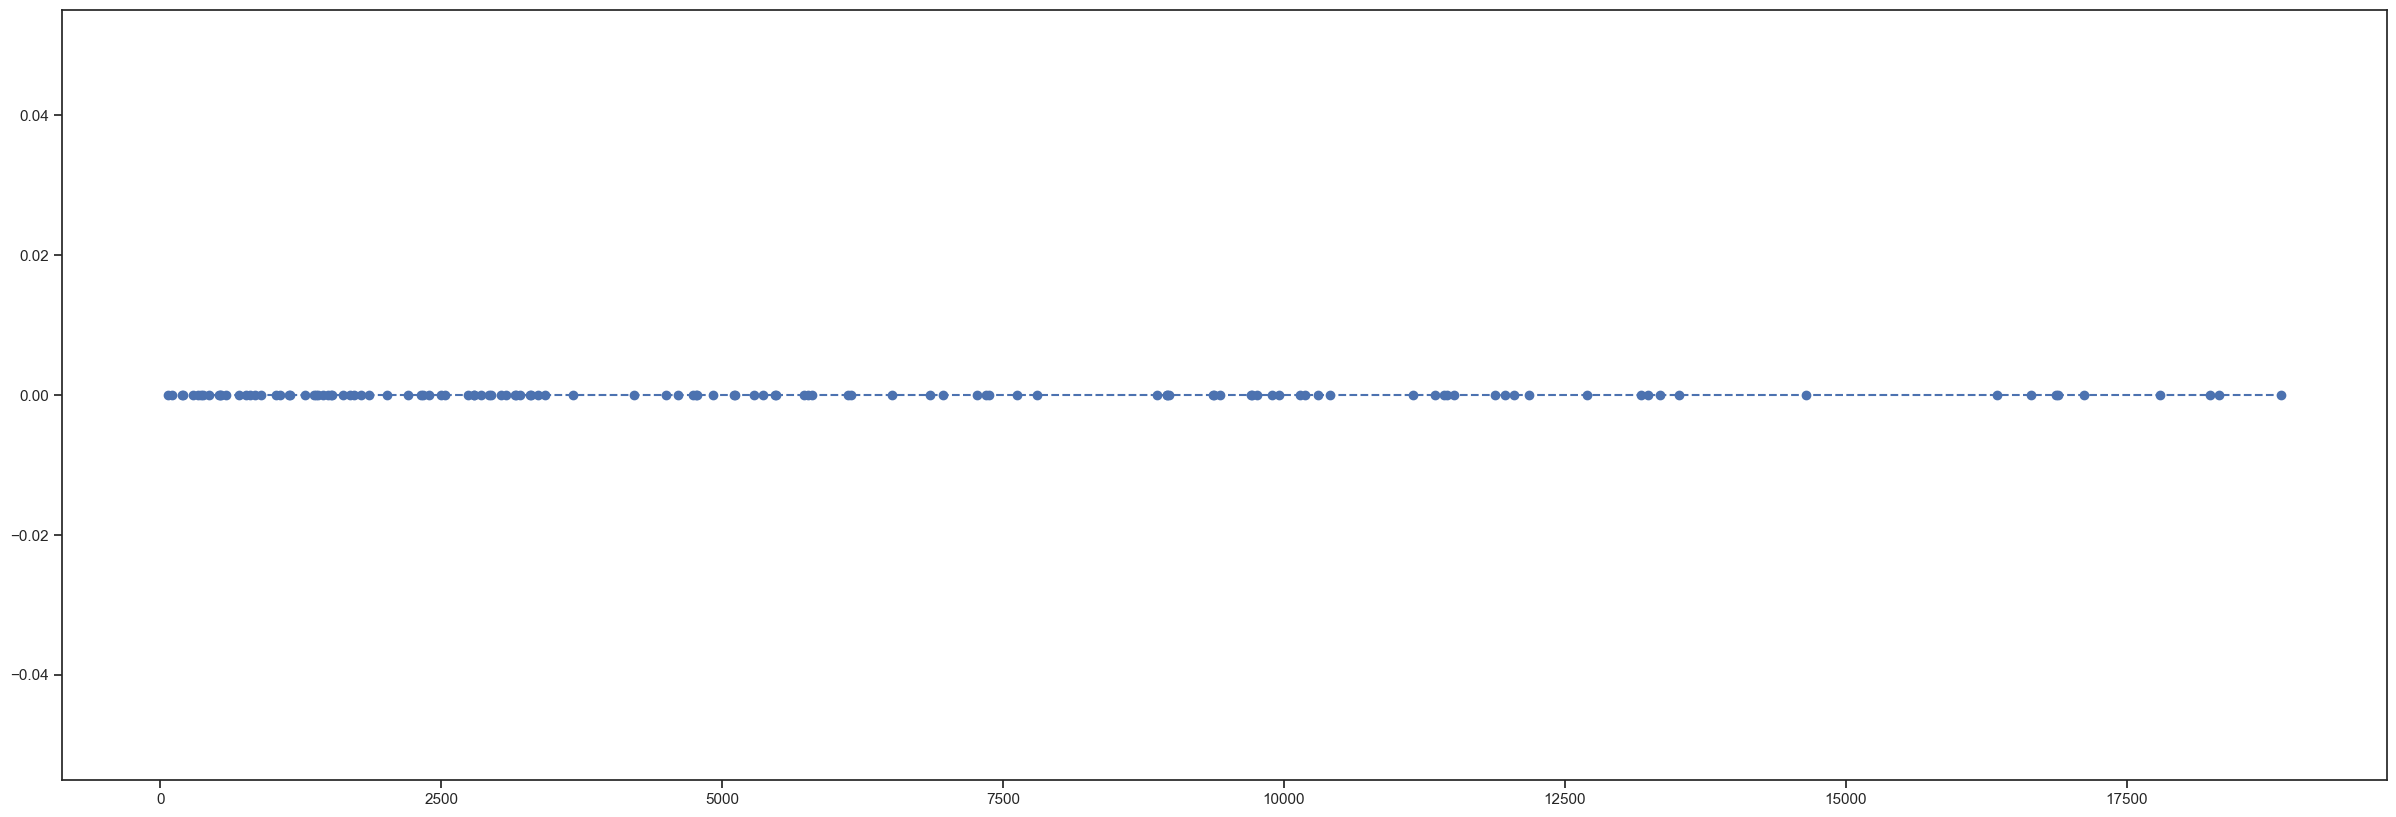

In [280]:
AD_markers_sig = AD_markers[AD_markers["Score_gda"] > 0.2]
df_pred_AD_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(AD_markers_sig["UniProt"])] 
print("Number of associated markers:", len(df_pred_AD_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_AD_markers[df_pred_AD_markers["CSF_proba"] > 0.5])/len(df_pred_AD_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_AD_markers[df_pred_AD_markers["CSF_proba"] < 0.5])/len(df_pred_AD_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.plot(df_pred_AD_markers.index, np.zeros(len(df_pred_AD_markers.index)), "--bo")
plt.show()

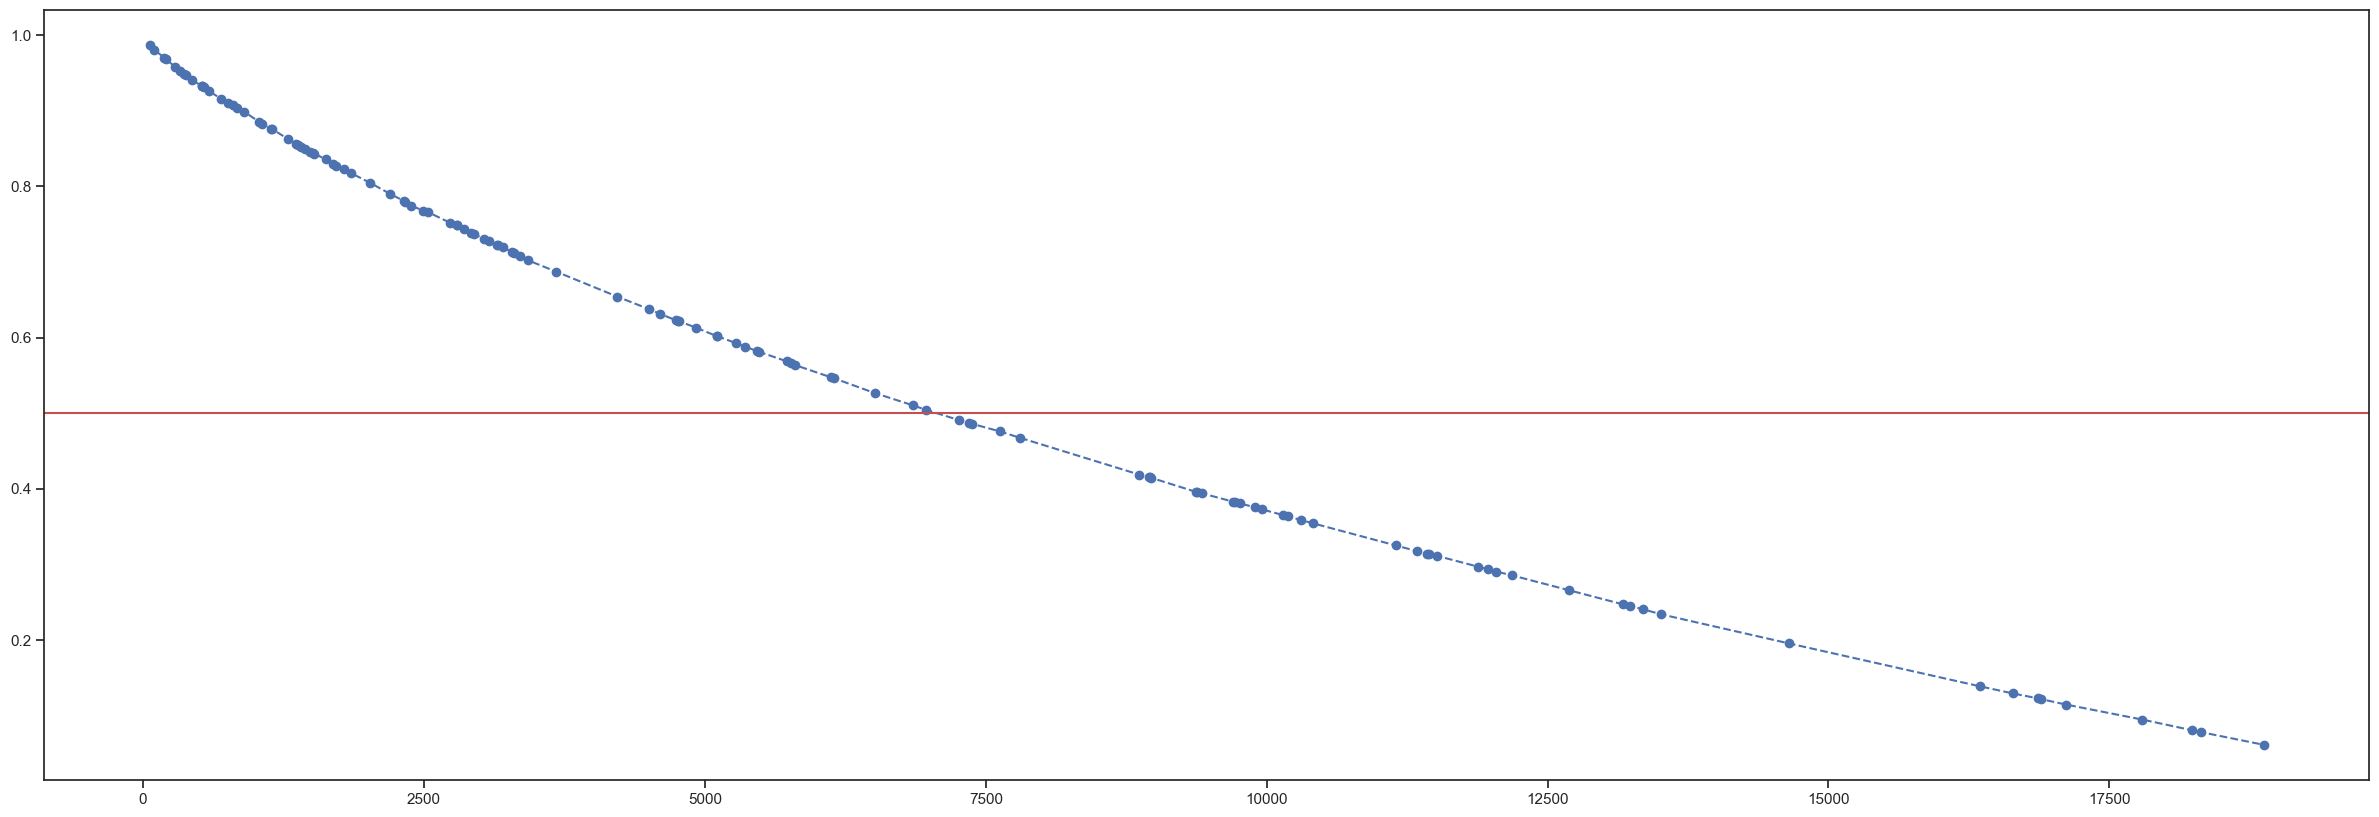

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.plot(df_pred_AD_markers.index, df_pred_AD_markers["CSF_proba"], "--bo")
ax.axhline(y=0.5, color="r", linestyle="-")
plt.show() # 0.5 threshold at rank 5943

### Dementia (DisGeNet)

Number of dementia markers: 23
Percent predicted as CSF secreted: 0.6956521739130435
Percent predicted as non-CSF secreted: 0.30434782608695654


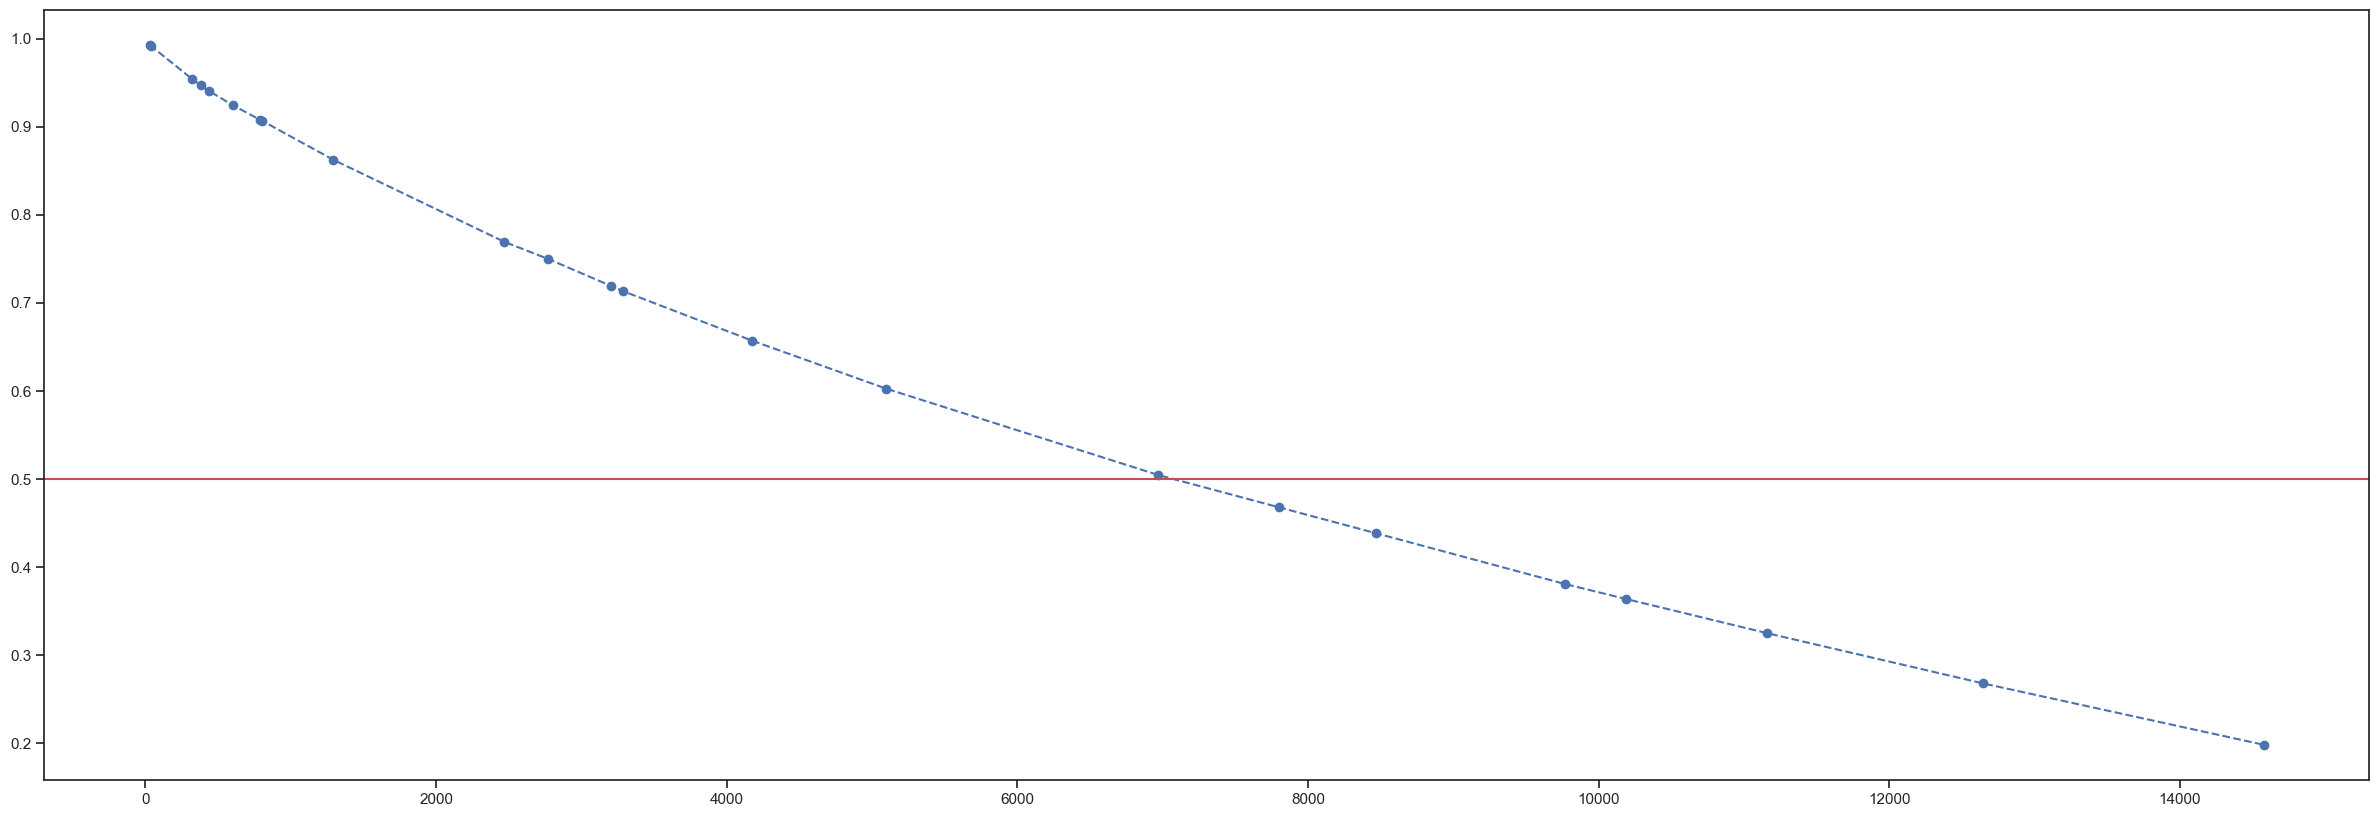

In [282]:
dementia_markers_sig = dementia_markers[dementia_markers["Score_gda"] >= 0.2]
df_pred_dementia_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(dementia_markers_sig["UniProt"])] 
print("Number of dementia markers:", len(df_pred_dementia_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["CSF_proba"] > 0.5])/len(df_pred_dementia_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["CSF_proba"] < 0.5])/len(df_pred_dementia_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,10))

plt.plot(df_pred_dementia_markers.index, df_pred_dementia_markers["CSF_proba"], "--bo")
ax.axhline(y=0.5, color="r", linestyle="-")
plt.show() # 0.5 threshold at rank 5943

## Probability scores of known & potential AD CSF biomarkers

Used literature:
- Olsson et al. (2016) CSF and blood biomarkers for the diagnosis of Alzheimer's disease: a systematic review and meta-analysis. https://doi.org/10.1016/S1474-4422(16)00070-3
- Molinuevo et al. (2018) Current state of Alzheimer’s fluid biomarkers. https://doi.org/10.1007/s00401-018-1932-x



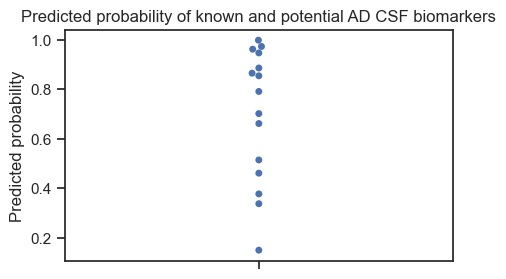

In [600]:
biomarkers_uniprots = ["P05067", "P10636", "Q92686", "Q9NZC2", "P07196", "P14136", "P36222", "P09104", "P62760", "P13500"
                      "P05413", "P56817", "P02778", "P60880", "P21579", "Q13148", "P37840"]

fig, ax = plt.subplots(1, 1, figsize=(5,3))

sns.swarmplot(y=df_detected_pred[df_detected_pred["Uniprot"].isin(biomarkers_uniprots)]["Score_lr_l2_2plus"], dodge=True)
ax.set(title="Predicted probability of known and potential AD CSF biomarkers", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Probability_AD_CSF_biomarkers.png", bbox_inches="tight")

In [284]:
#### TO DO ####

biomarker_dict = {"APP":"P05067", "MAPT":"P10636"}


print("Probability score for")
print("\tAPP: %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "P05067"]["CSF_proba"].values[0])
print("\tMAPT: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P10636"]["CSF_proba"].values[0]) 
print("\tNeurogranin: %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "Q92686"]["CSF_proba"].values[0]) 
print("\tTREM2: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "Q9NZC2"]["CSF_proba"].values[0]) 
print("\tNFL: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P07196"]["CSF_proba"].values[0]) 
print("\tGFAP: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P14136"]["CSF_proba"].values[0]) 
print("\tYKL-40: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P36222"]["CSF_proba"].values[0])
print("\tNSE: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P09104"]["CSF_proba"].values[0])
print("\tVLP-1: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P62760"]["CSF_proba"].values[0])
print("\tMCP-1: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P13500"]["CSF_proba"].values[0])
print("\tHFABP: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P05413"]["CSF_proba"].values[0])
print("\tBACE1: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P56817"]["CSF_proba"].values[0])
print("\tIP-10: %.04f" %  df_detected_pred[df_detected_pred["Uniprot"] == "P02778"]["CSF_proba"].values[0])
print("\tSNAP25 %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "P60880"]["CSF_proba"].values[0])
print("\tSynaptotagmin %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "P21579"]["CSF_proba"].values[0])
print("\tTDP-43 %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "Q13148"]["CSF_proba"].values[0]) # No studies on CSF according to reference
print("\tAlpha-synuclein %.04f" % df_detected_pred[df_detected_pred["Uniprot"] == "P37840"]["CSF_proba"].values[0])

Probability score for
	APP: 0.8628
	MAPT: 0.9070
	Neurogranin: 0.9788
	TREM2: 0.4675
	NFL: 0.5932
	GFAP: 0.5669
	YKL-40: 0.8210
	NSE: 0.7757
	VLP-1: 0.5267
	MCP-1: 0.7814
	HFABP: 0.7000
	BACE1: 0.8300
	IP-10: 0.7986
	SNAP25 0.8022
	Synaptotagmin 0.8664
	TDP-43 0.2635
	Alpha-synuclein 0.9921


### Candidates from MIRIADE consortium

In [285]:
print("Rank of probability for")
print("\tCRH:", df_pred[df_pred["Uniprot"] == "P06850"].index[0])
print("\tMMP1:", df_detected_pred[df_detected_pred["Uniprot"] == "P03956"].index[0])
print("\tGBA:", df_detected_pred[df_detected_pred["Uniprot"] == "P04062"].index[0])

print("\tPEBP1:", df_detected_pred[df_detected_pred["Uniprot"] == "P30086"].index[0])
print("\tSPON1:", df_detected_pred[df_detected_pred["Uniprot"] == "Q9HCB6"].index[0])
print("\tTNFSF13:", df_detected_pred[df_detected_pred["Uniprot"] == "O75888"].index[0])

print("\tVAMP2:", df_detected_pred[df_detected_pred["Uniprot"] == "P63027"].index[0])
print("\tGluR4:", df_detected_pred[df_detected_pred["Uniprot"] == "P48058"].index[0])
print("\tNPTX2:", df_detected_pred[df_detected_pred["Uniprot"] == "P47972"].index[0])
print("\tGAP43:", df_detected_pred[df_detected_pred["Uniprot"] == "P17677"].index[0])

Rank of probability for
	CRH: 5727
	MMP1: 563
	GBA: 5488
	PEBP1: 10934
	SPON1: 1329
	TNFSF13: 6040
	VAMP2: 1178
	GluR4: 5365
	NPTX2: 1434
	GAP43: 61


# Investigate false positives

These proteins were predicted to be secreted to the CSF but are annotated not to be. One explanation would be that these proteins are secreted to CSF but in such low concentrations that it is not (easily) possible to detect them in exploratory mass spectrometry studies.

In [286]:
# check brain elevated proteins that have not been found in CSF but are predicted to be CSF secreted
df_elevated_FP = df_elevated_non_CSF[df_elevated_non_CSF["CSF_proba"] > 0.5]
print("Number of false negative proteins in brain elevated dataset:", len(df_elevated_FP))

Number of false negative proteins in brain elevated dataset: 406


In [287]:
brain_exp_FP = brain_exp.merge(df_elevated_FP[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_CSF = brain_exp.merge(df_elevated_CSF[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")

print("Average brain expression of false positive proteins in brain elevated dataset: %.04f"
    % np.median(brain_exp_FP["log2(Brain expression)"]))
print("Average brain expression of CSF proteins in brain elevated dataset: %.04f" 
    % np.median(brain_exp_CSF["log2(Brain expression)"]))

Average brain expression of false positive proteins in brain elevated dataset: 4.6977
Average brain expression of CSF proteins in brain elevated dataset: 5.5329


In [288]:
df_elevated_FP["log2(Molecular weight)"] = np.log2(df_elevated_FP["Molecular weight"])
df_elevated_CSF["log2(Molecular weight)"] = np.log2(df_elevated_CSF["Molecular weight"])

print("Average false positive protein size in brain elevated dataset: %.04f"
    % np.median(df_elevated_FP["log2(Molecular weight)"]))
print("Average CSF protein size in brain elevated dataset: %.04f" 
    % np.median(df_elevated_CSF["log2(Molecular weight)"]))

Average false positive protein size in brain elevated dataset: 15.9244
Average CSF protein size in brain elevated dataset: 16.0460


## Check false positively predicted proteins for potential biomarkers

### Low brain expression

In [289]:
# how many proteins are confidently predicted to be in CSF and have a lower than average brain expression?
low_exp_biomarker_candidates = brain_exp_FP[(brain_exp_FP["CSF_proba"] > 0.75) & 
    (brain_exp_FP["log2(Brain expression)"] < 5.5329)]
print("Number of lowly expressed biomarker candidates:", len(low_exp_biomarker_candidates))

Number of lowly expressed biomarker candidates: 65


In [290]:
with open(data_path + "Biomarker_discovery/Biomarker_candidates_low_exp.txt", "w") as f:
    for item in low_exp_biomarker_candidates["Uniprot"]:
        f.write("%s\n" % item)

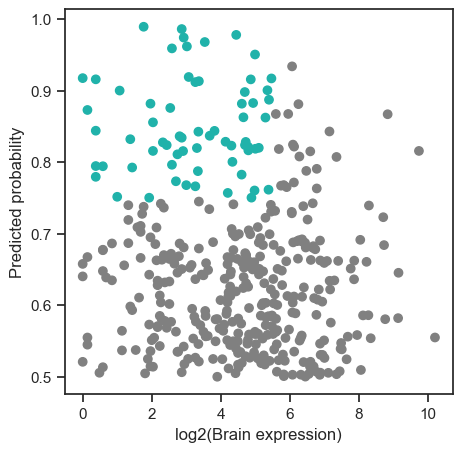

In [291]:
# set which points to colour based on brain expression and probability cut-off
col = np.where((brain_exp_FP["CSF_proba"] > 0.75) & (brain_exp_FP["log2(Brain expression)"] < 5.5329), "lightseagreen", "grey")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

plt.scatter(x="log2(Brain expression)", y="CSF_proba", data=brain_exp_FP, color=col)
ax.set(xlabel="log2(Brain expression)", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_false_positives_brain_expression_probability.png", bbox_inches="tight")

### Low molecular weight

In [292]:
# how many proteins are confidently predicted to be in CSF and have a low molecular weight?
low_mw_biomarker_candidates = df_elevated_FP[(df_elevated_FP["CSF_proba"] > 0.75) & 
    (df_elevated_FP["log2(Molecular weight)"] < 16.0460)]
print("Number of biomarker candidates:", len(low_mw_biomarker_candidates))

Number of biomarker candidates: 44


In [293]:
with open(data_path + "Biomarker_discovery/Biomarker_candidates_low_mw.txt", "w") as f:
    for item in low_mw_biomarker_candidates["Uniprot"]:
        f.write("%s\n" % item)

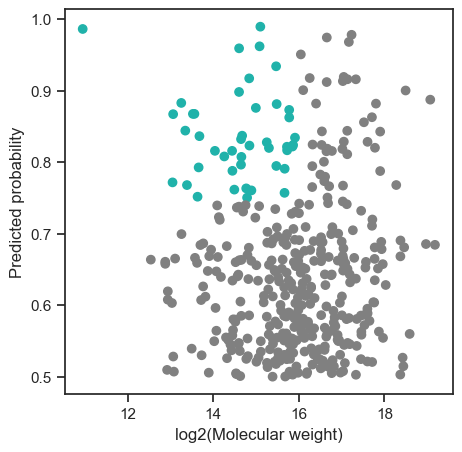

In [294]:
# set which points to colour based on brain expression and probability cut-off
col = np.where((df_elevated_FP["CSF_proba"] > 0.75) & (df_elevated_FP["log2(Molecular weight)"] < 16.0460), 
    "lightseagreen", "grey")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

plt.scatter(x="log2(Molecular weight)", y="CSF_proba", data=df_elevated_FP, color=col)
ax.set(xlabel="log2(Molecular weight)", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_false_positives_molecular_weight_probability.png", bbox_inches="tight")

### Compare protein groups

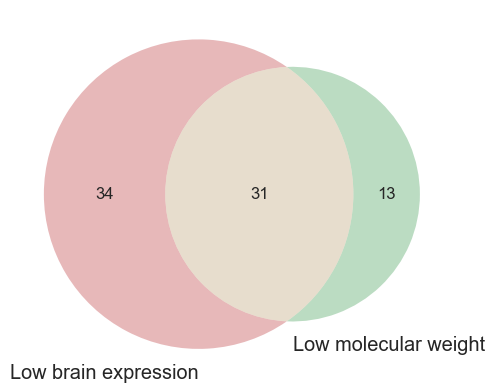

In [295]:
venn2([set(low_exp_biomarker_candidates["Uniprot"]), set(low_mw_biomarker_candidates["Uniprot"])], 
    ["Low brain expression", "Low molecular weight"])
plt.show()

In [296]:
Olink_proteins = pd.read_csv("C:/Users/kathi/Documents/Career/PhD/Data/OLINK_data/Original/Complete Biomarker List (July 1 2019).csv", 
    sep=";", skipfooter=2, engine="python")
Olink_proteins

,Protein,Uniprot ID,Panel(s),Notes
0,(Pyruvate dehydrogenase (acetyl-transferring))...,Q9P0J1,OD,NaN
1,"2,4-dienoyl-CoA reductase, mitochondrial (DECR1)",Q16698,CVD II,NaN
2,26S proteasome non-ATPase regulatory subunit 9...,O00233,Onc III,NaN
3,5'-AMP-activated protein kinase subunit beta-1...,Q9Y478,OD,NaN
4,5'-nucleotidase (5'-NT),P21589,Onc II,NaN
...,...,...,...,...
1156,Xaa-Pro aminopeptidase 2 (XPNPEP2),O43895,Onc II,NaN
1157,YTH domain-containing family protein 3 (YTHDF3),Q7Z739,Onc III,NaN
1158,Zinc finger and BTB domain-containing protein ...,Q05516,"IR, Cell-Reg",NaN
1159,Zinc finger and BTB domain-containing protein ...,Q13105,Cell-Reg,NaN


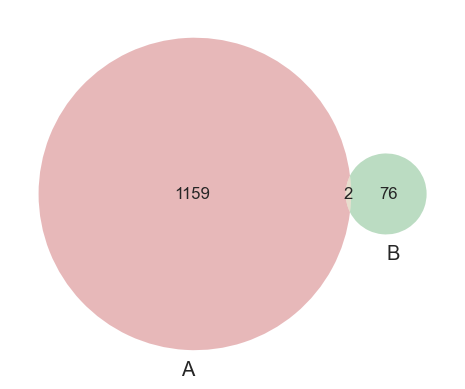

In [297]:
biomarker_candidates = set(low_exp_biomarker_candidates["Uniprot"]).union(set(low_mw_biomarker_candidates["Uniprot"]))
venn2([set(Olink_proteins["Uniprot ID"]), biomarker_candidates])
plt.show()

In [298]:
biomarker_candidates.intersection(set(Olink_proteins["Uniprot ID"]))

{'P68106', 'Q9GZV9'}

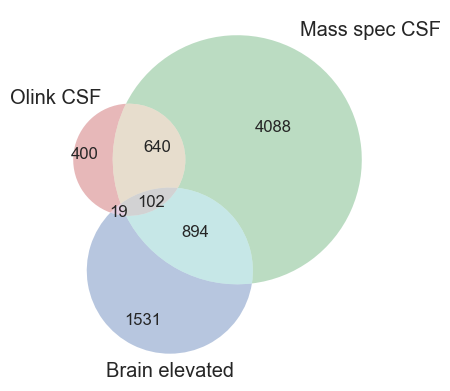

In [299]:
venn3([set(Olink_proteins["Uniprot ID"]), set(csf["Uniprot"]), set(brain_elevated["Uniprot"])], ["Olink CSF", "Mass spec CSF",
    "Brain elevated"])
plt.show()

In [300]:
biomarker_candidates_olink = set(Olink_proteins["Uniprot ID"]).intersection(set(brain_elevated["Uniprot"])) - set(csf["Uniprot"])
len(biomarker_candidates_olink)

19

In [301]:
biomarker_candidates_olink

{'O00253',
 'O60542',
 'O76038',
 'O95727',
 'P01135',
 'P05113',
 'P0CG37',
 'P20273',
 'P22466',
 'P50749',
 'P68106',
 'Q01344',
 'Q13574',
 'Q8N5S9',
 'Q92558',
 'Q9GZV9',
 'Q9UBT3',
 'Q9Y2J8',
 'Q9Y5L3'}

In [302]:
df_pred[df_pred["Uniprot"].isin(biomarker_candidates_olink)]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,CSF,CSF_proba,CSF_proba_2plus,CSF_proba_3plus
1237,P68106,MGVEIETISPGDGRTFPKKGQTCVVHYTGMLQNGKKFDSSRDRNKP...,108,11782.3744,0.055556,0.018519,0.046296,0.064815,0.055556,0.120370,...,0,0,0,0,0,0,-1,0.867457,0.911536,0.915798
1527,P20273,MHLLGPWLLLLVLEYLAFSDSSKWVFEHPETLYAWEGACVWIPCTY...,847,95346.5749,0.041322,0.027155,0.040142,0.068477,0.028335,0.063754,...,0,0,0,1,0,0,-1,0.843020,0.908085,0.959538
2567,Q9GZV9,MLGARLRLWVCALCSVCSMSVLRAYPNASPLLGSSWGGLIHLYTAT...,251,27953.5401,0.075697,0.027888,0.039841,0.035857,0.043825,0.079681,...,1,0,0,1,0,0,-1,0.763320,0.762718,0.702559
2930,Q9UBT3,MVAAVLLGLSWLCSPLGALVLDFNNIRSSADLHGARKGSQCLSDTD...,224,24875.4361,0.058036,0.093750,0.058036,0.049107,0.026786,0.080357,...,0,0,0,1,0,0,-1,0.737750,0.733373,0.756357
3726,P22466,MARGSALLLASLLLAAALSASAGLWSPAKEKRGWTLNSAGYLLGPH...,123,13301.9928,0.130081,0.000000,0.056911,0.065041,0.032520,0.073171,...,1,0,0,1,0,0,-1,0.684100,0.631955,0.675173
4326,O95727,MWWRVLSLLAWFPLQEASLTNHTETITVEEGQTLTLKCVTSLRKNS...,393,44640.2599,0.033079,0.015267,0.030534,0.091603,0.027990,0.035623,...,0,0,0,1,0,0,-1,0.647413,0.772512,0.820178
4577,Q01344,MIIVAHVLLILLGATEILQADLLPDEKISLLPPVNFTIKVTGLAQV...,420,47684.1527,0.059524,0.026190,0.047619,0.069048,0.035714,0.038095,...,0,0,0,1,0,0,-1,0.633215,0.664946,0.784731
4944,O00253,MLTAAVLSCALLLALPATRGAQMGLAPMEGIRRPDQALLPELPGLG...,132,14439.7658,0.128788,0.083333,0.037879,0.068182,0.022727,0.053030,...,0,0,0,1,0,0,-1,0.611885,0.511195,0.499530
5211,P01135,MVPSAGQLALFALGIVLAACQALENSTSPLSADPPVAAAVVSHFND...,160,17005.8365,0.143750,0.093750,0.031250,0.037500,0.031250,0.037500,...,1,0,0,1,0,0,-1,0.596136,0.415032,0.332133
6947,P05113,MRMLLHLSLLALGAAYVYAIPTEIPTSALVKETLALLSTHRTLLIA...,134,15237.6395,0.052239,0.014925,0.014925,0.089552,0.029851,0.059701,...,0,0,0,1,0,0,-1,0.505585,0.564227,0.349230


# Investigate false negatives

These proteins were predicted to not be secreted to the CSF but are annotated to be. One explanation would be that these proteins are actually false positives in the CSF mass spectrometry studies. False positive proteins are likely only found in only one study and with only one peptide.

In [584]:
df_elevated_FN = df_elevated_CSF[df_elevated_CSF["Score_lr_l2"] < 0.5]
print("Number of false negative proteins in brain elevated dataset:", len(df_elevated_FN))

Number of false negative proteins in brain elevated dataset: 255


## Check maximum peptide count of false negatives vs. all positive CSF proteins 

In [585]:
csf["#Peptides_max"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].max(axis=1)

csf_2plus = csf[csf["#Studies"] >= 2]
csf_3plus = csf[csf["#Studies"] >= 3]

### All CSF proteins

In [586]:
df_elevated_FN

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,Signal peptide,RNA_binding,DNA_binding,CSF,Score_lr_l1,Score_lr_l1_2plus,Score_lr_l1_3plus,Score_lr_l2,Score_lr_l2_2plus,Score_lr_l2_3plus
1797,Q12926,METQLSNGPTCNNTANGPTTINNNCSSPVDSGNTEDSKTNLIVNYL...,359,39503.4509,0.064067,0.013928,0.041783,0.041783,0.041783,0.083565,...,0,1,0,1,0.773214,0.812112,0.947979,0.469526,0.533261,0.910517
5142,O43426,MAFSKGFRIYHKLDPPPFSLIVETRHKEECLMFESGAVAVLSSAEK...,1573,173100.9816,0.069930,0.012715,0.050858,0.059123,0.048951,0.062301,...,0,1,0,1,0.582360,0.453905,0.337249,0.469258,0.336948,0.255239
5153,O94851,MGENEDEKQAQAGQVFENFVQASTCKGTLQAFNILTRHLDLDPLDH...,1957,219058.7148,0.071027,0.016863,0.043945,0.084313,0.037302,0.055187,...,0,0,0,1,0.582084,0.461183,0.254335,0.496763,0.433287,0.215975
5651,P29122,MPPRAPPAPGPRPPPRAAAATDTAAGAGGAGGAGGAGGPGFRPLAP...,969,106419.0257,0.085655,0.057792,0.049536,0.054696,0.026832,0.084623,...,0,0,0,1,0.561997,0.645260,0.692202,0.441032,0.619855,0.686995
5704,O14529,MAANVGSMFQYWKRFDLRRLQKELNSVASELSARQEESEHSHKHLI...,1486,161675.0131,0.085464,0.006057,0.038358,0.100269,0.020188,0.067295,...,0,0,1,1,0.559903,0.357421,0.229603,0.253187,0.141431,0.136537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18213,Q96A00,MAAQRLGKRVLSKLQSPSRARGPGGSPGGLQKRHARVTVKYDRREL...,147,16692.7992,0.054422,0.006803,0.061224,0.095238,0.006803,0.088435,...,0,0,0,1,0.131861,0.042578,0.016345,0.108683,0.050692,0.012780
18270,Q9GZX3,MWLPRVSSTAVTALLLAQTFLLLFLVSRPGPSSPAGGEARVHVLVL...,395,44098.3569,0.111392,0.020253,0.032911,0.043038,0.045570,0.050633,...,0,0,0,1,0.130270,0.054496,0.026751,0.095769,0.055976,0.021448
18537,Q9BQI9,MLFIFPLSLPWRPSCWKESCSTGQRQAGRSREDSVTPPPSSPWPTP...,281,31330.4460,0.064057,0.032028,0.046263,0.067616,0.021352,0.064057,...,0,0,0,1,0.120934,0.030988,0.023471,0.062632,0.025740,0.017968
18969,P23610,MAAAAAGLGGGGAGPGPEAGDFLARYRLVSNKLKKRFLRKPNVAEA...,371,39102.5606,0.183288,0.018868,0.018868,0.067385,0.026954,0.078167,...,0,0,0,1,0.104337,0.026527,0.036971,0.104901,0.031400,0.041930


Fraction of proteins identified with only one matching peptide in false negatives: 0.4824
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.2221


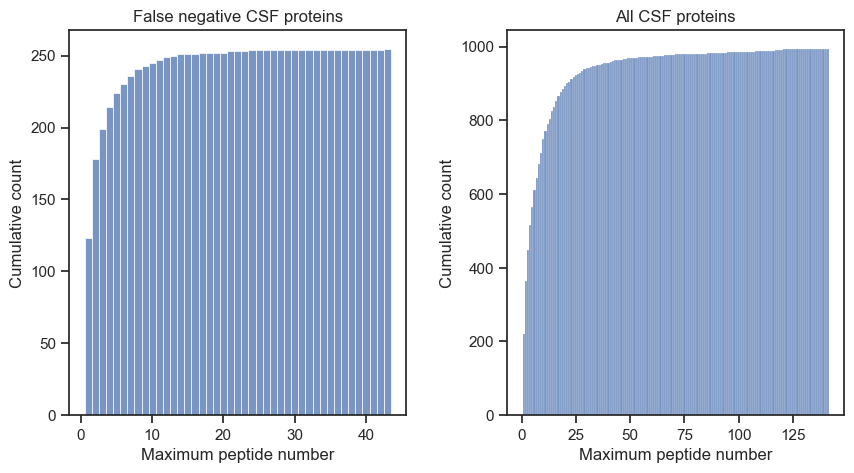

In [305]:
df_elevated_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
df_elevated_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(df_elevated_FN_peptides[df_elevated_FN_peptides["#Peptides_max"] == 1])/len(df_elevated_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(df_elevated_CSF_peptides[df_elevated_CSF_peptides["#Peptides_max"] == 1])/len(df_elevated_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=df_elevated_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=df_elevated_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides.png", bbox_inches="tight")

### 2+ studies CSF proteins

Fraction of proteins identified with only one matching peptide in false negatives: 0.1321
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.0520


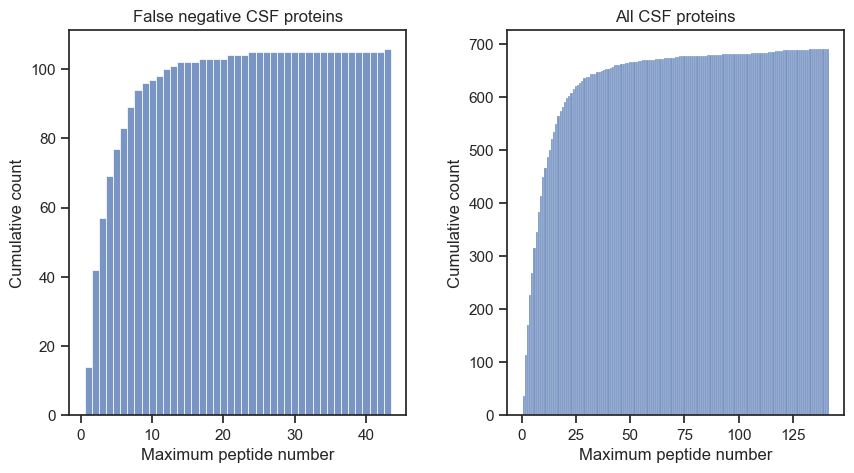

In [306]:
csf_2plus_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf_2plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
csf_2plus_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf_2plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(csf_2plus_FN_peptides[csf_2plus_FN_peptides["#Peptides_max"] == 1])/len(csf_2plus_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(csf_2plus_CSF_peptides[csf_2plus_CSF_peptides["#Peptides_max"] == 1])/len(csf_2plus_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=csf_2plus_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=csf_2plus_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides_2plus.png", bbox_inches="tight")

### 3+ studies CSF proteins

Fraction of proteins identified with only one matching peptide in false negatives: 0.0156
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.0055


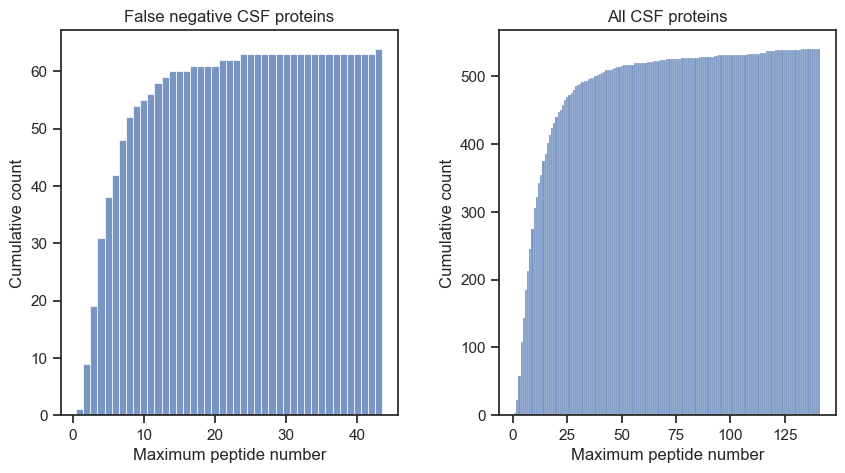

In [307]:
csf_3plus_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf_3plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
csf_3plus_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf_3plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(csf_3plus_FN_peptides[csf_3plus_FN_peptides["#Peptides_max"] == 1])/len(csf_3plus_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(csf_3plus_CSF_peptides[csf_3plus_CSF_peptides["#Peptides_max"] == 1])/len(csf_3plus_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=csf_3plus_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=csf_3plus_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides_3plus.png", bbox_inches="tight")

In [574]:
CSF_proba_peptides

,Uniprot,CSF_proba,#Peptides_max
0,Q8TDW7,0.999143,23.0
1,Q9NYQ8,0.997923,117.0
2,Q9HCU4,0.997121,25.0
3,Q9NYQ7,0.996787,9.0
4,Q9NZR2,0.996120,56.0
...,...,...,...
990,Q8IUM7,0.094190,1.0
991,Q8NBL3,0.091675,2.0
992,Q9BQI9,0.062632,2.0
993,Q9Y4Z2,0.057994,1.0


In [580]:
df_elevated_FN_peptides

,Uniprot,#Peptides_max,Number of peptides
0,O15165,2.0,2
1,O94851,2.0,2
2,P78352,5.0,5
3,Q15911,2.0,2
4,Q9BUP0,5.0,5
...,...,...,...
250,Q8IUM7,1.0,1
251,Q8NBL3,2.0,2
252,Q9BQI9,2.0,2
253,Q9Y4Z2,1.0,1


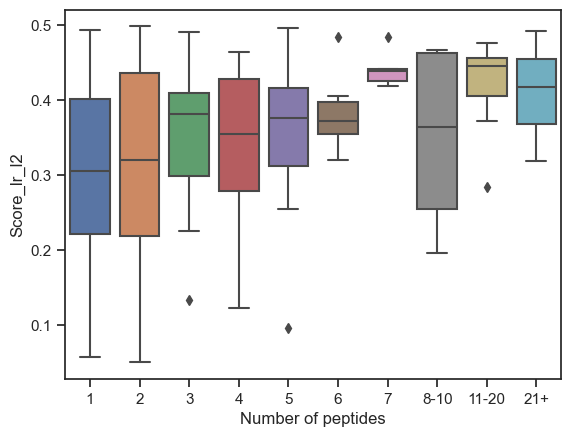

In [590]:
def peptide_category(number):
    if number == 0:
        return "0"
    if number == 1:
        return "1"
    if number == 2:
        return "2"
    if number == 3:
        return "3"
    if number == 4:
        return "4"
    if number == 5:
        return "5"
    if number == 6:
        return "6"
    if number == 7:
        return "7"
    if 7 < number < 10:
        return "8-10"
    if 11 <= number < 21:
        return "11-20"
    if number >= 21:
        return "21+"

df_elevated_FN_peptides_proba = df_elevated_FN[["Uniprot", "Score_lr_l2"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
df_elevated_FN_peptides_proba["Number of peptides"] = df_elevated_FN_peptides_proba["#Peptides_max"].apply(peptide_category)

sns.boxplot(x="Number of peptides",  y="Score_lr_l2", data=df_elevated_FN_peptides_proba,
            order=["1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"])
plt.show()

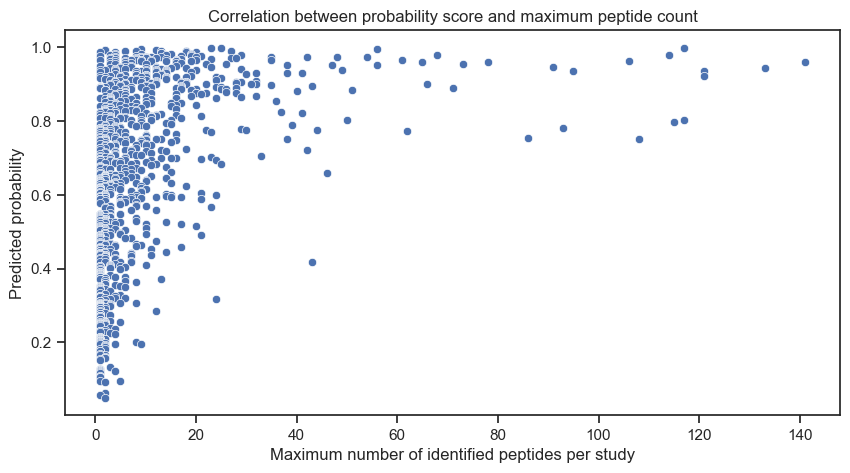

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

CSF_proba_peptides = df_elevated_CSF[["Uniprot", "CSF_proba"]].merge(csf[["Uniprot", "#Peptides_max"]])
sns.scatterplot(y="CSF_proba", x="#Peptides_max", data=CSF_proba_peptides)
ax.set(title="Correlation between probability score and maximum peptide count", 
          xlabel="Maximum number of identified peptides per study", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_max_peptides_probability.png", bbox_inches="tight")

# Check brain exclusive proteins

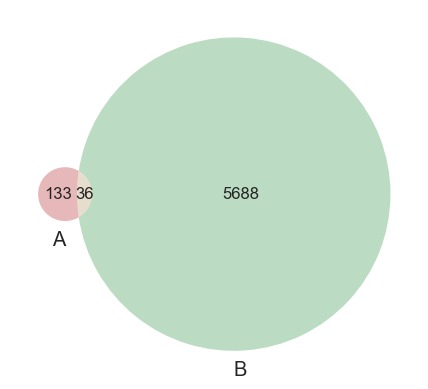

In [309]:
venn2([set(brain_exclusive["Uniprot"]), set(csf["Uniprot"])])
plt.show()

In [591]:
brain_exclusive_in_csf = set(brain_exclusive["Uniprot"]).intersection(set(csf["Uniprot"]))

In [592]:
df_pred_brain_exclusive = df_pred[df_pred["Uniprot"].isin(brain_exclusive_in_csf)]
df_pred_brain_exclusive[:5]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,Signal peptide,RNA_binding,DNA_binding,CSF,Score_lr_l1,Score_lr_l1_2plus,Score_lr_l1_3plus,Score_lr_l2,Score_lr_l2_2plus,Score_lr_l2_3plus
189,Q9Y5G5,MAAPQSRPRRGELILLCALLGTLWEIGRGQIRYSVPEETDKGSFVG...,932,101478.7091,0.076180,0.007511,0.065451,0.059013,0.027897,0.072961,...,1,1,0,1,0.940469,0.978268,0.989040,0.925521,0.965326,0.988475
210,Q9Y5H7,MVYSRRGSLGSRLLLLWLLLAYWKAGSGQLHYSIPEEAKHGTFVGR...,936,102046.9274,0.077991,0.010684,0.057692,0.069444,0.029915,0.067308,...,1,0,0,1,0.936902,0.983293,0.985274,0.970925,0.989625,0.991780
235,Q9NQ76,MRVFCVGLLLFSVTWAAPTFQPQTEKTKQSCVEEQRQEEKNKDNIG...,525,58418.2954,0.043810,0.003810,0.060952,0.083810,0.028571,0.089524,...,1,0,0,1,0.933192,0.982837,0.985401,0.962918,0.981401,0.986622
251,Q9Y5H6,MDYHWRGELGSWRLLLLLLLLAAWKVGSGQLHYSVPEEAKHGTFVG...,950,103049.7814,0.078947,0.011579,0.065263,0.066316,0.029474,0.072632,...,1,0,0,1,0.930707,0.980136,0.982510,0.967126,0.987324,0.989741
343,P0C091,MAGASRHPTGTPRQLLVALACLLLSRPALQGRASSLGTEPDPALYL...,2139,238175.8065,0.049088,0.007480,0.070126,0.062646,0.043478,0.065919,...,1,0,0,1,0.918383,0.958405,0.955042,0.921364,0.961144,0.951720


In [594]:
(df_pred_brain_exclusive["Score_lr_l2"] > 0.5).sum()/len(df_pred_brain_exclusive)
np.mean(df_pred_brain_exclusive["Score_lr_l2"])

0.6236725298240245

In [595]:
(df_pred_brain_exclusive["Score_lr_l2_2plus"] > 0.5).sum()/len(df_pred_brain_exclusive)
np.mean(df_pred_brain_exclusive["Score_lr_l2_2plus"])

0.6113183043411787

In [596]:
(df_pred_brain_exclusive["Score_lr_l2_3plus"] > 0.5).sum()/len(df_pred_brain_exclusive)
np.mean(df_pred_brain_exclusive["Score_lr_l2_3plus"])

0.5857752526649297

# Nerea's biomarker candidates [MIRIADE]

In [315]:
df_pred_biomarkers_Nerea = df_pred[df_pred["Uniprot"].isin(biomarkers_Nerea["Uniprot"])]
df_pred_biomarkers_Nerea

df_pred[df_pred["Uniprot"] == "Q13148"]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,CSF,CSF_proba,CSF_proba_2plus,CSF_proba_3plus
12754,Q13148,MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,414,44739.3391,0.062802,0.014493,0.05314,0.05314,0.05314,0.13285,...,0,0,0,0,1,1,-1,0.263486,0.149331,0.234206


In [316]:
(df_pred_biomarkers_Nerea["CSF_proba_3plus"] > 0.5).sum()/len(df_pred_biomarkers_Nerea)

0.7889273356401384

In [317]:
biomarkers_Nerea_pred = biomarkers_Nerea.merge(df_pred[["Uniprot", "CSF_proba", "CSF_proba_3plus"]], on="Uniprot", how="left")
biomarkers_Nerea_pred

,Uniprot,Gene name,Protein name,CSF_proba,CSF_proba_3plus
0,Q9Y6Q6,TNFRSF11A,TNR11,0.878444,0.925624
1,Q9Y653,ADGRG1,AGRG1,0.434500,0.268372
2,Q9Y624,F11R,JAM1,0.902096,0.968808
3,Q9Y336,SIGLEC9,SIGL9,0.790571,0.953907
4,Q9Y2T3,GDA,GUAD,0.417778,0.142718
...,...,...,...,...,...
285,O00300,TNFRSF11B,TR11B,0.715333,0.662145
286,O00253,AGRP,AGRP,0.611885,0.499530
287,P02748,C9,CO9,0.934211,0.888765
288,P01011,SERPINA3,AACT,0.627260,0.476860


In [318]:
biomarkers_Nerea_pred.to_excel(data_path + "Biomarker_discovery/Biomarkers_Nerea_predictions.xlsx", index=False)

In [319]:
brain_exp_features = brain_exp.merge(df_detected_pred, on="Uniprot", how="inner")
brain_exp_features

,Uniprot,Brain expression,log2(Brain expression),Sequence,Length,Molecular weight,A,C,D,E,...,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,CSF,CSF_proba,CSF_proba_2plus,CSF_proba_3plus
0,O43612,352.2,8.460251,MNLPSTKVSWAAVTLLLLLLLLPPALLSSGAAAQPLPDCCRQKTCS...,131,13362.5680,0.152672,0.045802,0.007634,0.015267,...,0,0,0,1,0,0,1,0.727881,0.619663,0.717485
1,P51861,38856.0,15.245850,MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...,262,31278.1934,0.022901,0.007634,0.137405,0.087786,...,0,0,0,0,0,0,-1,0.015004,0.004298,0.004018
2,P01185,5271.0,12.363861,MPDTMLPACFLGLLAFSSACYFQNCPRGGKRAMSDLELRQCLPCGP...,164,17324.5964,0.115854,0.103659,0.042683,0.067073,...,1,0,0,1,0,0,1,0.919971,0.917367,0.936019
3,Q96PE5,149.9,7.227857,MSFSLNFTLPANTTSSPVTGGKETDCGPSLGLAAGIPLLVATALLV...,141,15682.6689,0.070922,0.014184,0.035461,0.099291,...,0,0,0,0,0,0,1,0.256090,0.304301,0.143914
4,Q9BZE3,34.3,5.100137,MEGSNGFGIDSILSHRAGSPALPKGDPLLGDCRSPLELSPRSESSS...,327,35074.0476,0.103976,0.015291,0.055046,0.048930,...,0,0,0,0,0,1,-1,0.024153,0.005739,0.004206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,A4D1E1,2.2,1.137504,MACYLVISSRHLSNGHYRGIKGVFRGPLCKNGSPSPDFAEKKSTAK...,1349,152571.1215,0.042254,0.034841,0.046701,0.061527,...,1,0,0,0,0,0,-1,0.286426,0.160876,0.092689
2538,Q05481,30.4,4.925999,MPGTPGSLEMGLLTFRDVAIEFSPEEWQCLDTAQQNLYRNVMLENY...,1191,137215.9465,0.045340,0.067170,0.009236,0.097397,...,0,0,0,0,0,1,-1,0.151375,0.119000,0.025985
2539,Q8TCW7,1.3,0.378512,MEQIWLLLLLTIRVLPGSAQFNGYNCDANLHSRFPAERDISVYCGV...,415,45529.4831,0.050602,0.031325,0.045783,0.024096,...,0,0,0,1,0,0,-1,0.794671,0.706180,0.866832
2540,Q96LW9,43.6,5.446256,MASTEEQYDLKIVKVEEDPIWDQETHLRGNNFSGQEASRQLFRQFC...,406,47292.5570,0.039409,0.041872,0.029557,0.133005,...,1,0,0,0,0,1,-1,0.058427,0.034733,0.015604


In [320]:
corr_all = brain_exp_features.corr()
corr_all["Hydrophobic"].sort_values(ascending=False, key=abs)[:40]

Hydrophobic              1.000000
Polarity_low             0.985716
Solubility              -0.855299
Turn_NSP                -0.699239
F                        0.677734
Disorder_NSP            -0.673406
Buried                   0.670156
Exposed                 -0.657578
I                        0.608573
Volume_small            -0.603096
L                        0.571862
PredHel                  0.562275
ExpAA                    0.561227
Helix_NSP                0.556453
V                        0.551664
Polarity_medium         -0.530646
PredHel_binary           0.529487
Polarizability_low      -0.523500
Charge_neutral           0.518563
Polarity_large          -0.511678
Polar                   -0.500207
Neutral                 -0.500011
First60ExpAA             0.495549
P                       -0.487142
Instability index       -0.472369
Volume_medium            0.471731
Nucleus                 -0.451310
Charge_positive         -0.436877
E                       -0.435443
W             